In [105]:
import numpy as np 
import pandas as pd 
import tensorflow as tf 
import matplotlib.pyplot as plt 
from sklearn import linear_model
from statsmodels.tsa.arima_model import ARMA, ARIMA
from statsmodels.tsa.stattools import adfuller, arma_order_select_ic, acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
# look for cycles in data shorter than one year
from scipy.fftpack import rfft, irfft, fftfreq

from pandas import Series,DataFrame
import time
from datetime import date
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
import cPickle
from sklearn import metrics
from gensim.models import Word2Vec
import logging
import os
import math

from keras.models import Sequential
from keras.models import Model
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.layers.normalization import BatchNormalization
from keras.layers import Merge, Input, concatenate
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger, EarlyStopping
from keras.optimizers import RMSprop, Adam, SGD, Nadam
from keras.layers.advanced_activations import *
from keras.layers import Convolution1D, MaxPooling1D, AtrousConvolution1D
from keras.layers.recurrent import LSTM, GRU
from keras import regularizers
from keras.utils import plot_model
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
#from yahoo_finance import Share 
import random 
import datetime
%matplotlib inline

In [3]:
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="2"

# Step 1: 

Get the historical market position data (major indexes like NASDAQ/S&P500 and individual stock) and market news from multiple public sources – such as Google Finance, Yahoo Finance, Investing.com, CalTech, Bloomberg,  .., etc.

In [7]:
from pandas_datareader import data as pdr
import fix_yahoo_finance as yf
yf.pdr_override() # <== that's all it takes :-)

def get(tickers, startdate, enddate):
    def data(ticker):
        return (pdr.get_data_yahoo(ticker, start=startdate, end=enddate))
    datas = map (data, tickers)
    return(pd.concat(datas, keys=tickers, names=['Ticker', 'Date']))

tickers = ['AAPL', 'MSFT', 'IBM', 'GOOG','BAC','WMT']
all_data = get(tickers, datetime.datetime(2006, 10, 1), datetime.datetime(2012, 1, 1))
all_data.head()

[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded
[*********************100%***********************]  1 of 1 downloaded


,
Ticker,Date


In [133]:
#apple stock
aapl = all_data[all_data.index.get_level_values('Ticker') == 'AAPL']
aapl.reset_index('Ticker', inplace=True)
aapl = aapl.drop('Ticker', 1)

In [134]:
aapl.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-10-02,10.728572,10.838572,10.614285,10.694285,7.239566,178159800
2006-10-03,10.635715,10.707143,10.455714,10.582857,7.164135,197677200
2006-10-04,10.585714,10.780000,10.451428,10.768572,7.289855,207270700
2006-10-05,10.647142,10.880000,10.590000,10.690000,7.236666,170970800
2006-10-06,10.631429,10.720000,10.544286,10.602858,7.177672,116739700


In [135]:
aapl.to_csv('aapl.csv') #aple stock 

In [136]:
aapl = pd.read_csv('aapl.csv')
aapl.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2006-10-02,10.728572,10.838572,10.614285,10.694285,7.239566,178159800
1,2006-10-03,10.635715,10.707143,10.455714,10.582857,7.164135,197677200
2,2006-10-04,10.585714,10.780000,10.451428,10.768572,7.289855,207270700
3,2006-10-05,10.647142,10.880000,10.590000,10.690000,7.236666,170970800
4,2006-10-06,10.631429,10.720000,10.544286,10.602858,7.177672,116739700


In [137]:
aapl['Date'] = pd.to_datetime(aapl['Date'])
aapl.index = aapl['Date']
del aapl['Date']

In [138]:
aapl.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-10-02,10.728572,10.838572,10.614285,10.694285,7.239566,178159800
2006-10-03,10.635715,10.707143,10.455714,10.582857,7.164135,197677200
2006-10-04,10.585714,10.780000,10.451428,10.768572,7.289855,207270700
2006-10-05,10.647142,10.880000,10.590000,10.690000,7.236666,170970800
2006-10-06,10.631429,10.720000,10.544286,10.602858,7.177672,116739700


In [139]:
#aapl['2006']

In [140]:
#####
#Microsoft stock
msft = all_data[all_data.index.get_level_values('Ticker') == 'MSFT']
msft.reset_index('Ticker', inplace=True)
msft = msft.drop('Ticker', 1)

In [141]:
msft.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-10-02,27.320000,27.490000,27.150000,27.360001,20.873104,52908100
2006-10-03,27.370001,27.480000,27.209999,27.370001,20.880735,39386200
2006-10-04,27.389999,27.959999,27.370001,27.940001,21.315592,82191200
2006-10-05,27.920000,28.110001,27.780001,27.920000,21.300335,81967200
2006-10-06,27.760000,28.000000,27.650000,27.870001,21.262192,36452200


In [142]:
msft.to_csv('msft.csv') #microsoft stock 

In [143]:
msft = pd.read_csv('msft.csv')

msft['Date'] = pd.to_datetime(msft['Date'])
msft.index = msft['Date']
del msft['Date']

msft.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-10-02,27.320000,27.490000,27.150000,27.360001,20.873104,52908100
2006-10-03,27.370001,27.480000,27.209999,27.370001,20.880735,39386200
2006-10-04,27.389999,27.959999,27.370001,27.940001,21.315592,82191200
2006-10-05,27.920000,28.110001,27.780001,27.920000,21.300335,81967200
2006-10-06,27.760000,28.000000,27.650000,27.870001,21.262192,36452200


In [144]:
################
#####
#IBM stock
ibm = all_data[all_data.index.get_level_values('Ticker') == 'IBM']
ibm.reset_index('Ticker', inplace=True)
ibm = ibm.drop('Ticker', 1)

In [145]:
ibm.to_csv('ibm.csv') #IBM stock 

In [146]:
ibm = pd.read_csv('ibm.csv')

ibm['Date'] = pd.to_datetime(ibm['Date'])
ibm.index = ibm['Date']
del ibm['Date']

ibm.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-10-02,81.760002,82.470001,81.580002,81.870003,62.664627,4483300
2006-10-03,81.879997,82.260002,81.559998,81.650002,62.496235,4838500
2006-10-04,81.650002,83.250000,81.629997,83.099998,63.606079,6119300
2006-10-05,82.809998,83.209999,82.599998,82.919998,63.468285,4956600
2006-10-06,82.930000,83.779999,82.500000,83.139999,63.636684,5340900


In [147]:
################
#####
#IBM stock
goog = all_data[all_data.index.get_level_values('Ticker') == 'GOOG']
goog.reset_index('Ticker', inplace=True)
goog = goog.drop('Ticker', 1)

In [148]:
goog.to_csv('goog.csv') #Google stock 

In [149]:
goog = pd.read_csv('goog.csv')

goog['Date'] = pd.to_datetime(goog['Date'])
goog.index = goog['Date']
del goog['Date']

goog.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-10-02,199.651459,201.688217,199.105011,199.422943,199.422943,7351200
2006-10-03,199.348434,201.916733,197.808441,200.714539,200.714539,11000400
2006-10-04,201.176544,206.541641,200.222748,206.506866,206.506866,13410200
2006-10-05,206.010101,207.768661,204.102509,204.574448,204.574448,11654800
2006-10-06,203.784576,209.591812,203.551102,208.891357,208.891357,14768300


In [8]:
################
#####
#IBM stock
bac = all_data[all_data.index.get_level_values('Ticker') == 'BAC']
bac.reset_index('Ticker', inplace=True)
bac = bac.drop('Ticker', 1)

In [17]:
#bac.to_csv('bac.csv') #BankOfAmerica stock 

NameError: name 'bac' is not defined

In [68]:
bac = pd.read_csv('bac.csv')

bac['Date'] = pd.to_datetime(bac['Date'])
bac.index = bac['Date']
del bac['Date']

bac.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-10-02,53.529999,53.680000,53.299999,53.619999,43.512402,7378600
2006-10-03,53.630001,54.570000,53.570000,54.410000,44.153492,13591200
2006-10-04,54.290001,54.849998,54.150002,54.820000,44.486210,12570700
2006-10-05,54.560001,54.869999,54.270000,54.520000,44.242756,8653700
2006-10-06,54.349998,54.470001,54.110001,54.240002,44.015545,8968900


In [153]:
################
#####
#Walmart stock
wmt = all_data[all_data.index.get_level_values('Ticker') == 'WMT']
wmt.reset_index('Ticker', inplace=True)
wmt = wmt.drop('Ticker', 1)

In [154]:
wmt.to_csv('wmt.csv') #Walmart stock 

In [155]:
wmt = pd.read_csv('wmt.csv')

wmt['Date'] = pd.to_datetime(wmt['Date'])
wmt.index = wmt['Date']
del wmt['Date']

wmt.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-10-02,48.619999,48.860001,48.029999,48.439999,37.121307,18006000
2006-10-03,48.459999,49.500000,48.060001,49.459999,37.902973,14986500
2006-10-04,48.310001,49.610001,48.130001,49.549999,37.971939,24777600
2006-10-05,49.470001,49.470001,48.099998,48.410000,37.098320,25071000
2006-10-06,48.419998,48.980000,48.240002,48.320000,37.029335,15445600


# Step 2:  
Conduct your analysis using an analytics tool (Python or R or Apache Spark or ..) to answer the following questions - please support your answers with proper graphs and respective interpretation/explanation/reasoning.

In [157]:
#Six Company dataframe
#aapl,msft,ibm,goog,bac,wmt(Apple, Microsoft, IBM, Google, BankOfAmerica, Walmart)

In [158]:
pd.DataFrame([aapl['Open'],msft['Open'],ibm['Open'],goog['Open'],bac['Open'],wmt['Open']]).T.head()

,Open,Open,Open,Open,Open,Open
Date,,,,,,
2006-10-02,10.728572,27.320000,81.760002,199.651459,53.529999,48.619999
2006-10-03,10.635715,27.370001,81.879997,199.348434,53.630001,48.459999
2006-10-04,10.585714,27.389999,81.650002,201.176544,54.290001,48.310001
2006-10-05,10.647142,27.920000,82.809998,206.010101,54.560001,49.470001
2006-10-06,10.631429,27.760000,82.930000,203.784576,54.349998,48.419998


## I. 
Are there patterns that will explain noise, normal, and unusual market conditions?  Can you apply any unsupervised ML techniques to support this?

In [162]:
#Calculate the daily percent change. Daily percent change is given by r_t = p_t/p_{t-1} -1; Where 
#where p is the price, t is the time (a day in this case) and r is the return.

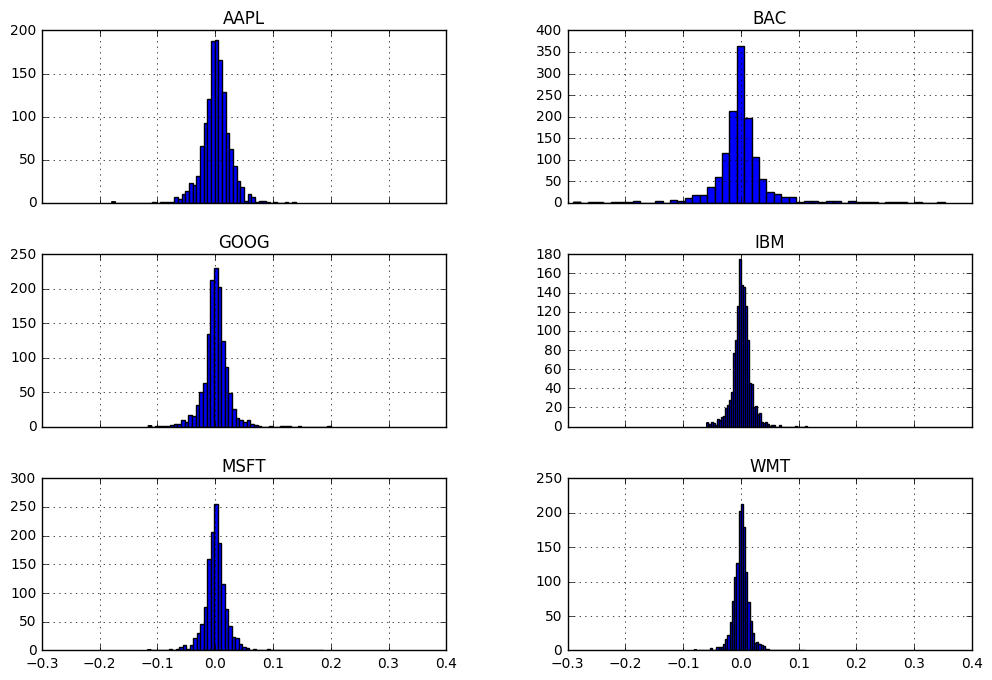

In [163]:
daily_close_px = all_data[['Adj Close']].reset_index().pivot('Date', 'Ticker', 'Adj Close')

# Calculate the daily percentage change for `daily_close_px`
daily_pct_change = daily_close_px.pct_change()

# Plot the distributions
daily_pct_change.hist(bins=50, sharex=True, figsize=(12,8))

# Show the resulting plot
plt.show()

In [169]:
#All the above histograms are normally distributed and centered at mean=0. Also more variability or spread of the 
#histogram then there is more variation of the stock price. In above BAC(Bank of America) has most price fluctuation.

In [172]:
daily_pct_change['BAC'].describe(), daily_pct_change['WMT'].describe()

(count    1322.000000
 mean       -0.000457
 std         0.048012
 min        -0.289694
 25%        -0.016298
 50%        -0.000977
 75%         0.013015
 max         0.352691
 Name: BAC, dtype: float64, count    1322.000000
 mean        0.000340
 std         0.013949
 min        -0.080639
 25%        -0.006666
 50%         0.000480
 75%         0.006731
 max         0.110731
 Name: WMT, dtype: float64)

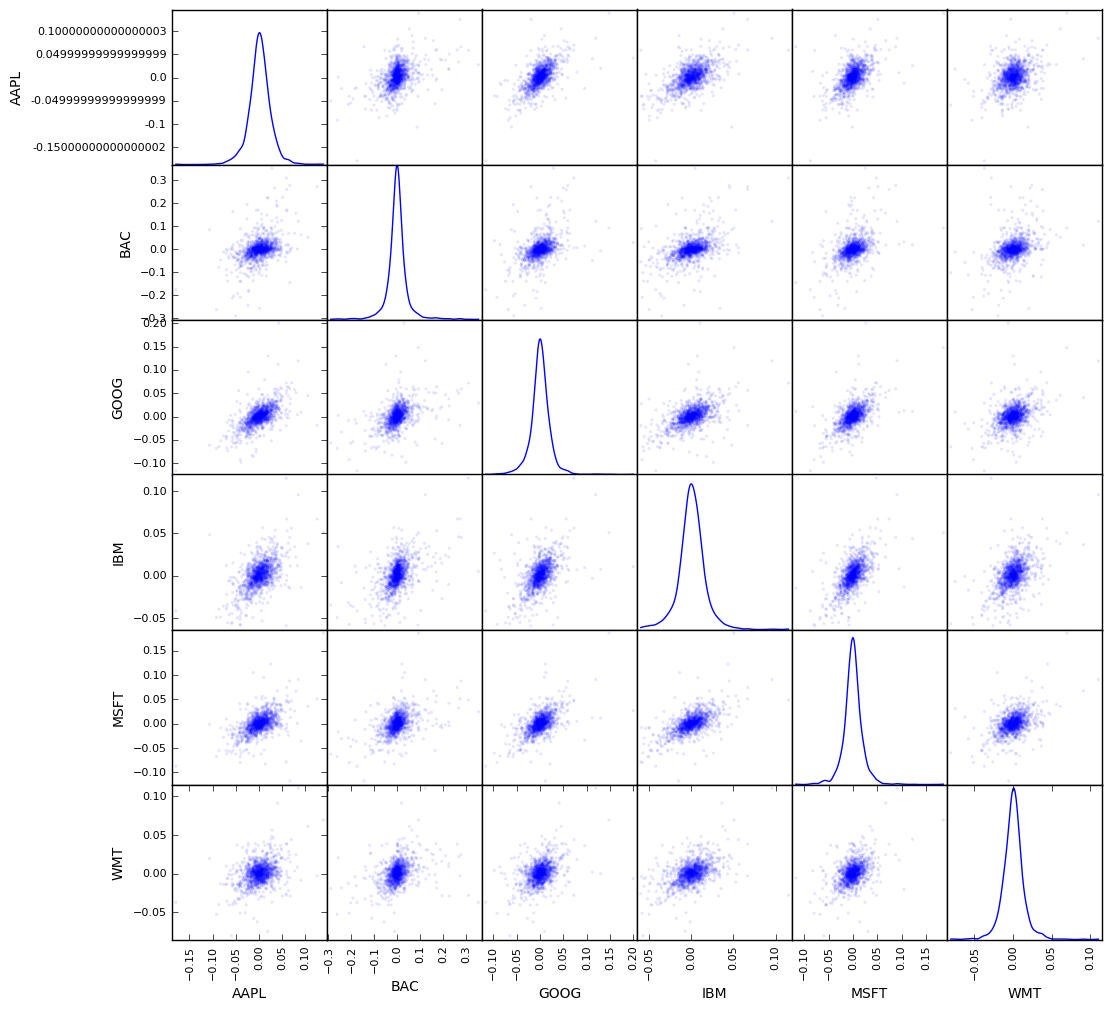

In [173]:
# Plot a scatter matrix with the `daily_pct_change` data 
pd.plotting.scatter_matrix(daily_pct_change, diagonal='kde', alpha=0.1,figsize=(12,12))

# Show the plot
plt.show()

In [175]:
#Above plot shows scatter plot and correlation between the daily percent change for each stock. The diagonal plot 
#shows the density plot and the scatter diagram with more elongated ellipse is more correlated with each other. 

In [ ]:
#Below plot shows the volatility of the stocks. In general higher volatility means it is riskier in terms of investment
# Clearly below diagram shows BankofAmerica has highest volatility during 2008-2010. I am suspecting this is housing
#market brust recession. Infact all stock has higher volatility in this time-frame but BAC stock was most volatile
#during this period[2008-2010]. 

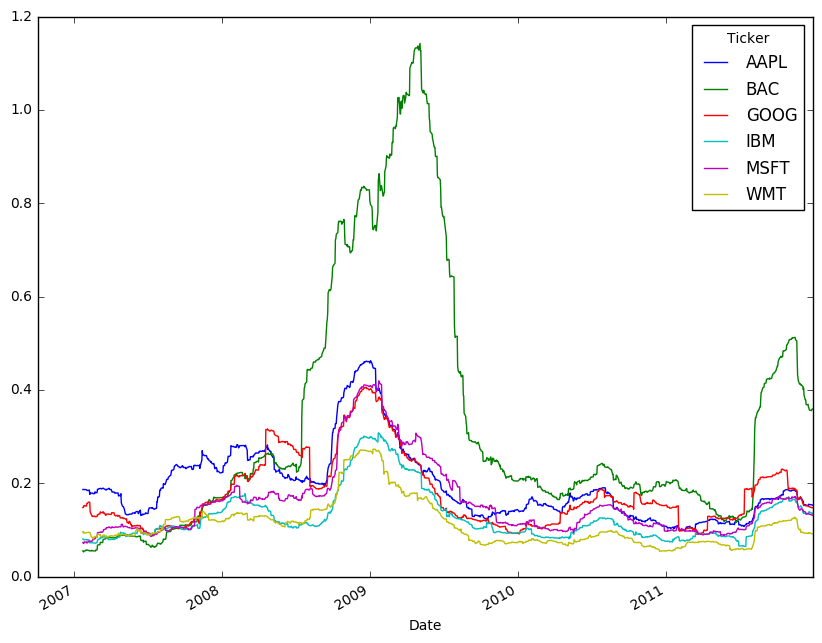

In [178]:
# Define the minumum of periods to consider 
min_periods = 75 

# Calculate the volatility
vol = daily_pct_change.rolling(min_periods).std() * np.sqrt(min_periods) 

# Plot the volatility
vol.plot(figsize=(10, 8))

# Show the plot
plt.show()

In [179]:
#lets check anamolities for BAC stock

In [210]:
# convert to log scale
wmt['LogAdjClose'] = np.log(wmt['Adj Close'])

In [211]:
wmt.head(2)

,Open,High,Low,Close,Adj Close,Volume,LogAdjClose
Date,,,,,,,
2006-10-02,48.619999,48.860001,48.029999,48.439999,37.121307,18006000,3.614191
2006-10-03,48.459999,49.500000,48.060001,49.459999,37.902973,14986500,3.635030


In [192]:
#Test the stationarity of the timeseries signal using Dickey-Fuller test
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = pd.rolling_mean(timeseries, window=12)
    rolstd = pd.rolling_std(timeseries, window=12)

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print 'Results of Dickey-Fuller Test:'
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print dfoutput

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


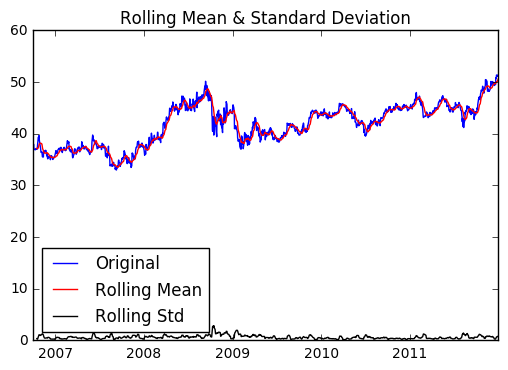

Results of Dickey-Fuller Test:
Test Statistic                   -1.150366
p-value                           0.694575
#Lags Used                       21.000000
Number of Observations Used    1301.000000
Critical Value (5%)              -2.863764
Critical Value (1%)              -3.435386
Critical Value (10%)             -2.567954
dtype: float64


In [212]:
test_stationarity(wmt['Adj Close'])

In [213]:
#Null hypothesis is signal, is non-stationary. p value(0.694)>>0.05, so we can't reject null hypothesis of signal
#being non-stationary. Hence signal is non-stationarity for bankofamerica 'Adj Close'. Lets make signal stationary.
#Some terms

##Trend: We say that a dataset has a trend when it has either a long-term increase or decrease.

##Seasonality: We say that a dataset has seasonality when it has patterns that repeat over known, 
##             fixed periods of time (e.g. monthly, quarterly, yearly).

##Heteroskedasticity: We say that a data is heteroskedastic when its variability is not constant 
##(i.e., its variance increases or decreases as a function of the explanatory variable).

##Stationarity: A stochastic process is called stationary if the mean and variance are constant 
##(i.e., their joint distribution does not change over time).

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


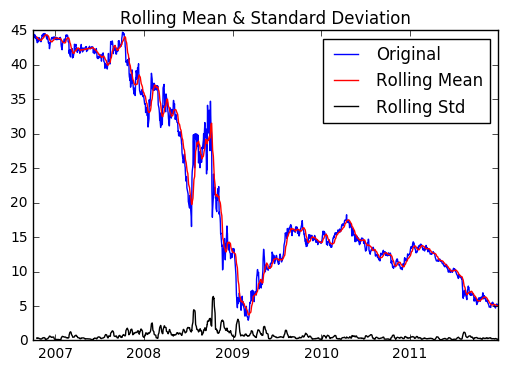

Results of Dickey-Fuller Test:
Test Statistic                   -1.185597
p-value                           0.679761
#Lags Used                       22.000000
Number of Observations Used    1300.000000
Critical Value (5%)              -2.863766
Critical Value (1%)              -3.435390
Critical Value (10%)             -2.567955
dtype: float64


In [216]:
#Similar for other stock
test_stationarity(bac['Adj Close'])

In [202]:
#Make BOF signal stationary.

In [231]:
bac['LogAdjCloseShift'] = bac['LogAdjClose']-bac['LogAdjClose'].shift()
bac['LogAdjCloseShift'].dropna(inplace=True)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).mean()
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:6: FutureWarning: pd.rolling_std is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=12,center=False).std()


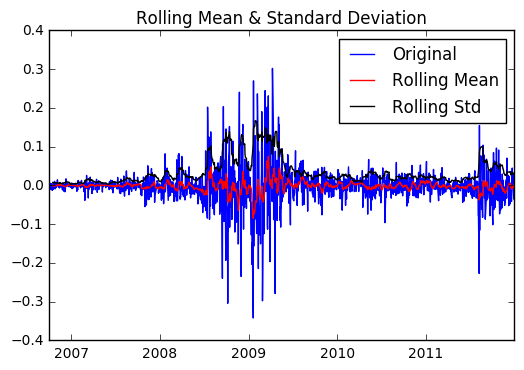

Results of Dickey-Fuller Test:
Test Statistic                -6.328166e+00
p-value                        2.951005e-08
#Lags Used                     2.200000e+01
Number of Observations Used    1.299000e+03
Critical Value (5%)           -2.863768e+00
Critical Value (1%)           -3.435394e+00
Critical Value (10%)          -2.567956e+00
dtype: float64


In [232]:
test_stationarity(bac['LogAdjCloseShift'])

In [233]:
#Signal is stationary. p-value(2.951005e-08)<<0.05. So, null hypothesis can be rejected ie. signal is stationary now.

In [249]:
bac['LogAdjClose'].dropna(inplace=True)

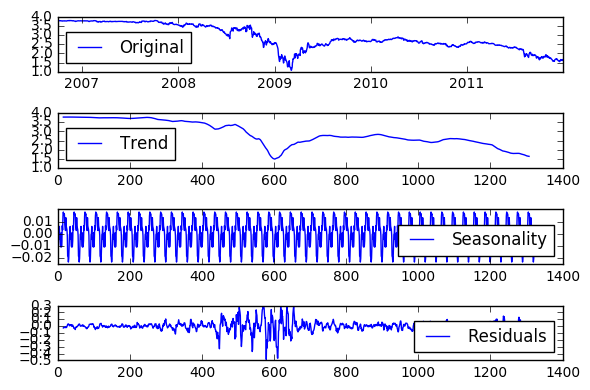

In [239]:
decomposition = seasonal_decompose(bac['LogAdjClose'].values, freq=30)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(bac['LogAdjClose'], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

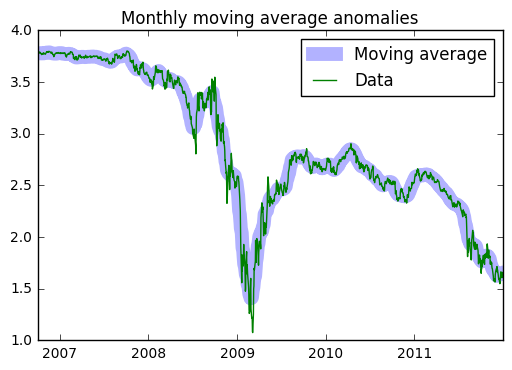

In [252]:
# smooth out noise
window = 21     # 5 days in week, 21 in month, 63 in quarter, 253 in year

ma = bac['LogAdjClose'].rolling(window=window, center=True).mean()
plt.plot(ma, lw=10, alpha=0.3, label='Moving average')
plt.plot(bac['LogAdjClose'], label='Data')
plt.legend(loc='best')
plt.title('Monthly moving average anomalies')
plt.show()

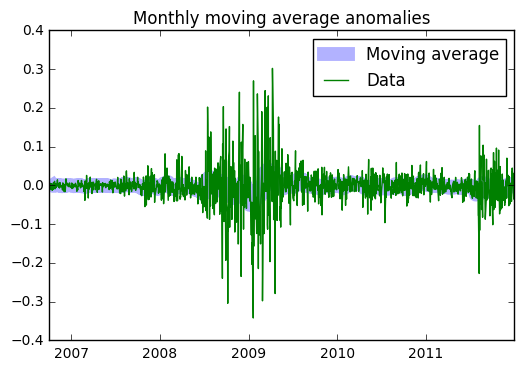

In [256]:
# smooth out noise
window = 21     # 5 days in week, 21 in month, 63 in quarter, 253 in year

ma = bac['LogAdjCloseShift'].rolling(window=window, center=True).mean()
plt.plot(ma, lw=10, alpha=0.3, label='Moving average')
plt.plot(bac['LogAdjCloseShift'], label='Data')
plt.legend(loc='best')
plt.title('Monthly moving average anomalies')
plt.show()

In [258]:
#Clearly around 2009, there is a lot of jitter which signify some unusal market condition happened. Also the moving 
#average is in general the mean statistics and around 2009 there is a huge fluctuation signifying some unusual trend.

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


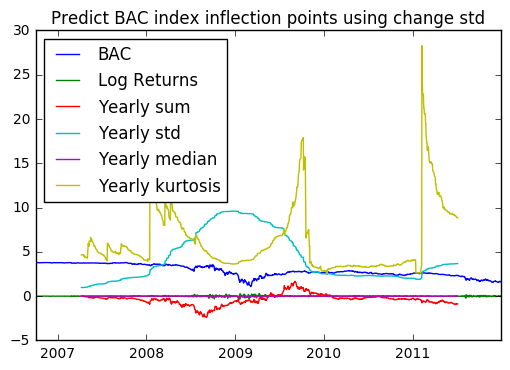

In [334]:
features = [bac.columns.values]

# switch to log data
data['logAdjClose'] = np.log(bac['Adj Close'])

# log returns
data['logReturnsBAC'] = data['logAdjClose'] - data['logAdjClose'].shift(1)


# remove nan row from target creation
data = data.dropna()


yr_sum = data.rolling(window=252, center=True).sum()['logReturnsBAC']
yr_std = data.rolling(window=252, center=True).std()['logReturnsBAC']
yr_median = data.rolling(window=252, center=True).median()['logReturnsBAC']
yr_kurtosis = data.rolling(window=252, center=True).kurt()['logReturnsBAC']


#plt.figure(figsize=(10,10))
plt.plot(data['logAdjClose'], label='BAC')
plt.plot(data['logReturnsBAC'], label='Log Returns')
plt.plot(yr_sum, label='Yearly sum')
plt.plot(yr_std * 100., label='Yearly std')
plt.plot(yr_median, label='Yearly median')
plt.plot(yr_kurtosis + 2, label='Yearly kurtosis')
plt.title("Predict BAC index inflection points using change std")

plt.legend(loc='best')
plt.show()

In [ ]:
#Large erro around 2009. skewness and kurtosis measure how its distribution differs from a normal distribution 
#and therefore provide an indication of the reliability of predictions based on the standard deviation. 
#kurtosis measures outliers

In [259]:
#Now we will use Deep Learning Autoencoder for finding some noise

In [265]:
bac['Adj Close'] = pd.to_numeric(bac['Adj Close'], errors='coerce')

# convert to log scale
bac['LogAdjClose'] = np.log(bac['Adj Close']) 
bac['dx'] = bac['LogAdjClose'] - bac['LogAdjClose'].shift(1)

data = bac[['LogAdjClose', 'dx']]
data = data.dropna()

In [269]:
# scale data
data['LogAdjClose'] = data['LogAdjClose'] - data['LogAdjClose'].min()
data['dx'] = data['dx'] - data['dx'].min()
data.head()

,LogAdjClose,dx
Date,,
2006-10-03,2.711728,0.356685
2006-10-04,2.719235,0.349566
2006-10-05,2.713747,0.336571
2006-10-06,2.708599,0.336910
2006-10-09,2.713564,0.347024


In [271]:
# need to break into input and output data samples
#data = data.resample('B').bfill()       # fill in missing days ( holidays..)
data = data.resample('B').bfill()       # fill in missing days ( holidays..)
weeks_df = [g for n, g in data.groupby(pd.TimeGrouper('W'))] #group by week
months_df = [g for n, g in data.groupby(pd.TimeGrouper('M'))]

print("data ", len(data))
print("weeks ", len(weeks_df))
print("months ", len(months_df))

# convert to numpy matrix
print(len(weeks_df))
weeks = []
for i in range(len(weeks_df)):
    row = weeks_df[i]
    x = np.asarray(row['LogAdjClose'].values)
    if(len(x)==5):
        weeks.append(x)
        #print(len(x))

w = np.asarray(weeks)

('data ', 1369)
('weeks ', 274)
('months ', 63)
274


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:4: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:5: FutureWarning: pd.TimeGrouper is deprecated and will be removed; Please use pd.Grouper(freq=...)


In [293]:
#It is just a dataframe group by week. There are 5 working days. So, group by 5 date.
weeks_df

[            LogAdjClose        dx
 Date                             
 2006-10-03     2.711728  0.356685
 2006-10-04     2.719235  0.349566
 2006-10-05     2.713747  0.336571
 2006-10-06     2.708599  0.336910,             LogAdjClose        dx
 Date                             
 2006-10-09     2.713564  0.347024
 2006-10-10     2.715763  0.344258
 2006-10-11     2.704904  0.331201
 2006-10-12     2.708967  0.346122
 2006-10-13     2.711360  0.344452,             LogAdjClose        dx
 Date                             
 2006-10-16     2.698779  0.329478
 2006-10-17     2.698221  0.341501
 2006-10-18     2.700639  0.344477
 2006-10-19     2.690365  0.331786
 2006-10-20     2.697102  0.348795,             LogAdjClose        dx
 Date                             
 2006-10-23     2.697847  0.342805
 2006-10-24     2.693552  0.337764
 2006-10-25     2.704164  0.352671
 2006-10-26     2.707491  0.345386
 2006-10-27     2.698593  0.333161,             LogAdjClose        dx
 Date               

In [291]:
#w is basically the LogAdjClose vector. Each array represent 1 week of data.Next row is next week data.
w

array([[2.71356376, 2.71576273, 2.70490424, 2.70896735, 2.71136011],
       [2.69877871, 2.69822069, 2.70063893, 2.69036544, 2.6971017 ],
       [2.69784739, 2.69355207, 2.70416379, 2.70749121, 2.69859288],
       ...,
       [0.56125099, 0.53710907, 0.52004681, 0.52576664, 0.51429408],
       [0.4730712 , 0.50850806, 0.52004681, 0.56491379, 0.58840216],
       [0.56674056, 0.56674056, 0.53145353, 0.56308406, 0.58123389]])

In [ ]:
#Autoencoder; We have 1 layer of autoencoder with number of hidden layer as 3. Basically 3 is the codebook for 
#representing the input data. Here error is the deviation from the expected value ie. if input is not equal to 
#(output=input). That is if autoencoder cannot perfectly replicate the input signal.

In [274]:
#Autoencoder

def get_batch(x, size):
    a = np.random.choice(len(x), size, replace=False)
    return x[a]

class Autoencoder:
    def __init__(self, n_input, n_hidden, epoch=100, learning_rate=0.001):

        x = tf.placeholder(dtype=tf.float32, shape=[None, n_input])
        with tf.name_scope('encode'):
            weights = tf.Variable(tf.random_normal([n_input, n_hidden], dtype=tf.float32), name='weights')
            biases = tf.Variable(tf.zeros([n_hidden]), name='biases')
            encoded = tf.nn.tanh(tf.matmul(x, weights) + biases)

        with tf.name_scope('decode'):
            weights = tf.Variable(tf.random_normal([n_hidden, n_input], dtype=tf.float32), name='weights')
            biases = tf.Variable(tf.zeros([n_input]), name='biases')
            decoded = tf.matmul(encoded, weights) + biases 
        
        self.epoch = epoch 
        self.learning_rate = learning_rate
        self.x = x
        self.encoded = encoded 
        self.decoded = decoded 
        
        self.loss = tf.sqrt(tf.reduce_mean(tf.square(tf.subtract(self.x, self.decoded))))
        self.train_op = tf.train.RMSPropOptimizer(self.learning_rate).minimize(self.loss)
        self.saver = tf.train.Saver()

    # batch training
    def train(self, data, batch_size=4):
        with tf.Session() as sess:
            sess.run(tf.global_variables_initializer())
            for i in range(self.epoch):
                for j in range(len(data)):
                    batch_data = get_batch(data, batch_size)
                    #assert all(x.shape == (4, 5) for x in batch_data)
                    #batch_data = np.vstack([np.expand_dims(x, 0) for x in batch_data])
                    l, _ = sess.run([self.loss, self.train_op], {self.x: batch_data})
                if i % 10 == 0:
                    print('Epoch {0}: loss = {1}'.format(i, l))
            self.saver.save(sess, 'model/ae_model.ckpt')

    def test(self, data):
        with tf.Session() as sess:
            self.saver.restore(sess, 'model/ae_model.ckpt')
            hidden, reconstructed = sess.run([self.encoded, self.decoded], {self.x: data})
            #print('input', data)
            #print('compressed', hidden)
            #print('reconstructed', reconstructed)

            return reconstructed

In [275]:
w.shape, len(w[0])

((273, 5), 5)

In [276]:
# train auto encoder
n_hidden = 3
n_input = len(w[0])
ae = Autoencoder(n_input, n_hidden)
ae.train(w)

Epoch 0: loss = 1.0845066309
Epoch 10: loss = 0.129189431667
Epoch 20: loss = 0.0942107215524
Epoch 30: loss = 0.150132894516
Epoch 40: loss = 0.138184711337
Epoch 50: loss = 0.0693776756525
Epoch 60: loss = 0.0225742589682
Epoch 70: loss = 0.0710631757975
Epoch 80: loss = 0.0221394598484
Epoch 90: loss = 0.0274052228779


In [277]:
print("test")
print(w[0], w[0].shape)
print( ae.test([w[0]]))

test
(array([2.71356376, 2.71576273, 2.70490424, 2.70896735, 2.71136011]), (5,))
INFO:tensorflow:Restoring parameters from model/ae_model.ckpt
[[2.672773  2.671404  2.6766264 2.6793292 2.6777737]]


In [278]:
errors = []
weeks = []
total = []
for i in range(int(len(w))):
    # get date for this week
    row = weeks_df[i]
    weeks.append( row.index[0] )

    # test this week
    z_in = w[i] 
    z_out = ae.test([w[i]])
    errors.append( np.sum(z_in - z_out) )

INFO:tensorflow:Restoring parameters from model/ae_model.ckpt
INFO:tensorflow:Restoring parameters from model/ae_model.ckpt
INFO:tensorflow:Restoring parameters from model/ae_model.ckpt
INFO:tensorflow:Restoring parameters from model/ae_model.ckpt
INFO:tensorflow:Restoring parameters from model/ae_model.ckpt
INFO:tensorflow:Restoring parameters from model/ae_model.ckpt
INFO:tensorflow:Restoring parameters from model/ae_model.ckpt
INFO:tensorflow:Restoring parameters from model/ae_model.ckpt
INFO:tensorflow:Restoring parameters from model/ae_model.ckpt
INFO:tensorflow:Restoring parameters from model/ae_model.ckpt
INFO:tensorflow:Restoring parameters from model/ae_model.ckpt
INFO:tensorflow:Restoring parameters from model/ae_model.ckpt
INFO:tensorflow:Restoring parameters from model/ae_model.ckpt
INFO:tensorflow:Restoring parameters from model/ae_model.ckpt
INFO:tensorflow:Restoring parameters from model/ae_model.ckpt
INFO:tensorflow:Restoring parameters from model/ae_model.ckpt
INFO:ten

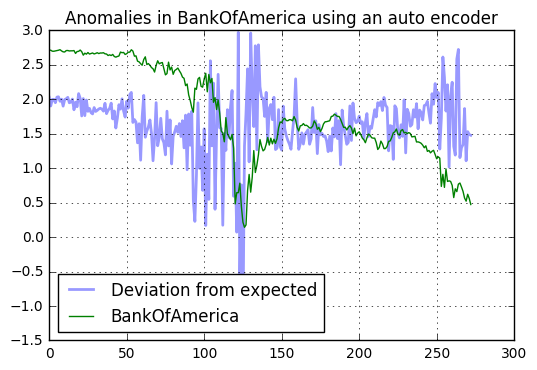

In [282]:
# plotting
# get nasdaq values for plotting
index = []
for i in range(int(len(w))):
    row = weeks_df[i]
    index.append(row['LogAdjClose'][0]) 

# convert errors to abs and scale up for plot
errors1 = np.asarray(errors)* 3 + 1.5
#errors1 = np.asarray(errors)

#plt.figure(figsize=(10,10))
plt.plot(errors1, label='Deviation from expected', alpha=0.4, lw=2)
plt.plot(index, label='BankOfAmerica')
plt.legend(loc='best')
plt.title("Anomalies in BankOfAmerica using an auto encoder")
plt.grid('on')
plt.show()

In [ ]:
#As shown above, green is the true signal and blue is errors signal. Clearly in the middle there is very zitter signal.
#There might be unusal activity in this range ie. 120 week of data ie. around 2009. See below to see 120 week's date.
#We can do similar analysis for other stocks too.

In [301]:
weeks_df[120]

,LogAdjClose,dx
Date,,
2009-01-19,0.482274,0.000000
2009-01-20,0.482274,0.000000
2009-01-21,0.752152,0.611937
2009-01-22,0.595253,0.185160
2009-01-23,0.684014,0.430820


# II. 
What are the stocks that cause the gain/loss in your selected portfolio (consists of the chosen stocks)? Please support your findings.

In [320]:
# reverse dates
#data = data.iloc[::-1]

# keep only Adj Close
bac['Adj Close'] = pd.to_numeric(bac['Adj Close'], errors='coerce')

# log of price is used in most stock market calculations
bac['LogAdjClose'] = np.log(bac['Adj Close']) 

# index change from prior day
bac['dx'] = bac['LogAdjClose'] - bac['LogAdjClose'].shift(1)

# check every thing looks okay
bac.head(4)

,Open,High,Low,Close,Adj Close,Volume,LogAdjClose,y,StationarySignal,LogAdjCloseShift,dx,GainLoss,i
Date,,,,,,,,,,,,,
2006-10-02,53.529999,53.680000,53.299999,53.619999,43.512402,7378600,3.773046,3.773046,39.739356,NaN,NaN,2,1
2006-10-03,53.630001,54.570000,53.570000,54.410000,44.153492,13591200,3.787672,3.771447,40.382045,0.014626,0.014626,3,2
2006-10-04,54.290001,54.849998,54.150002,54.820000,44.486210,12570700,3.795179,3.769847,40.716363,0.007507,0.007507,3,3
2006-10-05,54.560001,54.869999,54.270000,54.520000,44.242756,8653700,3.789692,3.768248,40.474508,-0.005488,-0.005488,2,4


In [306]:
data = bac

In [315]:
len(data)

1323

In [307]:
# look for patterns in the daily change 

# redo dx as high gain 4, low gain 3, low loss 2, high loss 1
# use this to set the dividers between high and average return days
print(data.dx.mean(), data.dx.median(), data.dx.max(), data.dx.min())

def gains_losses(d): #based upon dx

    if d >= 0.05: return 4
    elif d > 0.00: return 3
    elif d <= -0.05: return 1
    else: return 2

data['GainLoss'] = data['dx'].apply(gains_losses)
print("Count of days with good, bad and average returns: \n", data['GainLoss'].value_counts())

# what happens in the n trading days before a very good or bad day?
n_trading_days = 21     # 5/week, 21/month, 63/quarter, 252/year

# add a row count column to make it easier to fetch data slices
i = np.arange(1, len(data) + 1)
data['i'] = i

# set up storage
lowReturns = []
highReturns = []
slightlyLowReturns = []
slightlyHighReturns = []

for idx, row in data.iterrows():
    if row.i > n_trading_days:

        start = int(row.i - n_trading_days)
        end = int(row.i)
        pattern = np.asarray(data.iloc[start:end, :]['dx'].values)

        if row.GainLoss == 1:       # very bad day 
            lowReturns.append(pattern)

        if row.GainLoss == 2:       
            slightlyLowReturns.append(pattern)

        if row.GainLoss == 3:       
            slightlyHighReturns.append(pattern)

        if row.GainLoss == 4:       # very good day
            highReturns.append(pattern)

(-0.00160050515020735, -0.0009776791565259124, 0.30209560849066786, -0.34205904563130174)
('Count of days with good, bad and average returns: \n', 2    600
3    538
1    101
4     84
Name: GainLoss, dtype: int64)


In [318]:
lowReturns

[array([ 0.00901006,  0.00589844, -0.005326  ,  0.00266668, -0.00514929,
         0.00229155, -0.00669905, -0.01256154, -0.0240123 , -0.00339221,
        -0.02386817, -0.02655256,  0.00440509,  0.        , -0.00629862,
        -0.01016101,  0.02167824, -0.00104158,  0.00020855,  0.00602455,
        -0.05470044]),
 array([-0.00514929,  0.00229155, -0.00669905, -0.01256154, -0.0240123 ,
        -0.00339221, -0.02386817, -0.02655256,  0.00440509,  0.        ,
        -0.00629862, -0.01016101,  0.02167824, -0.00104158,  0.00020855,
         0.00602455, -0.05470044, -0.01321317, -0.01473878,  0.02466512,
        -0.05064657]),
 array([ 0.02132427, -0.01719929, -0.01272366, -0.00807323, -0.02103383,
         0.        , -0.04769683, -0.02961431,  0.00033746, -0.02633968,
         0.02024457,  0.01148263,  0.01797038, -0.03626995, -0.03020529,
        -0.00814013, -0.03765841, -0.04606341,  0.02819232, -0.00037538,
        -0.07004063]),
 array([-0.02103383,  0.        , -0.04769683, -0.02961

In [317]:
data.head(3)

,Open,High,Low,Close,Adj Close,Volume,LogAdjClose,y,StationarySignal,LogAdjCloseShift,dx,GainLoss,i
Date,,,,,,,,,,,,,
2006-10-02,53.529999,53.680000,53.299999,53.619999,43.512402,7378600,3.773046,3.773046,39.739356,NaN,NaN,2,1
2006-10-03,53.630001,54.570000,53.570000,54.410000,44.153492,13591200,3.787672,3.771447,40.382045,0.014626,0.014626,3,2
2006-10-04,54.290001,54.849998,54.150002,54.820000,44.486210,12570700,3.795179,3.769847,40.716363,0.007507,0.007507,3,3


In [308]:
# create np array columns = n_trading_days before high return day
high_returns = np.array(highReturns)
low_returns = np.array(lowReturns)
slightly_low_returns = np.array(slightlyLowReturns)
slightly_high_returns = np.array(slightlyHighReturns)


print(high_returns.shape)
print(slightly_high_returns.shape)
print(slightly_low_returns.shape)
print(low_returns.shape)

high_avg = high_returns.mean(axis=0)
low_avg = low_returns.mean(axis=0)
slightlyHigh_avg = np.nanmean(slightly_high_returns, axis=0)
slightlyLow_avg = np.nanmean(slightly_low_returns, axis=0)

for i in range(n_trading_days):
    print('%.5f, %.5f, %.5f, %.5f' %(high_avg[i], slightlyHigh_avg[i], slightlyLow_avg[i], low_avg[i]))

(84, 21)
(526, 21)
(591, 21)
(101, 21)
0.00524, -0.00008, -0.00226, -0.01175
-0.00266, 0.00054, -0.00246, -0.00719
-0.01636, -0.00026, -0.00177, 0.00456
-0.01170, 0.00052, -0.00017, -0.01271
-0.00439, 0.00238, -0.00250, -0.01465
-0.01210, -0.00238, 0.00078, -0.00316
-0.01899, -0.00147, -0.00012, 0.00330
-0.01331, 0.00050, -0.00018, -0.01170
-0.00083, 0.00030, -0.00303, -0.00465
-0.01554, -0.00116, 0.00148, -0.01139
0.00246, 0.00047, -0.00170, -0.01607
0.00607, -0.00162, -0.00244, -0.00394
0.00350, -0.00400, -0.00076, 0.00028
-0.00832, -0.00162, -0.00212, 0.00615
-0.00323, -0.00308, -0.00205, 0.00916
-0.02177, -0.00122, -0.00162, 0.01279
-0.00888, -0.00080, -0.00066, -0.00541
-0.01978, -0.00023, 0.00031, -0.00533
0.00150, 0.00080, -0.00240, -0.01291
-0.01105, -0.00148, 0.00014, -0.00511
0.10640, 0.01540, -0.01554, -0.09873


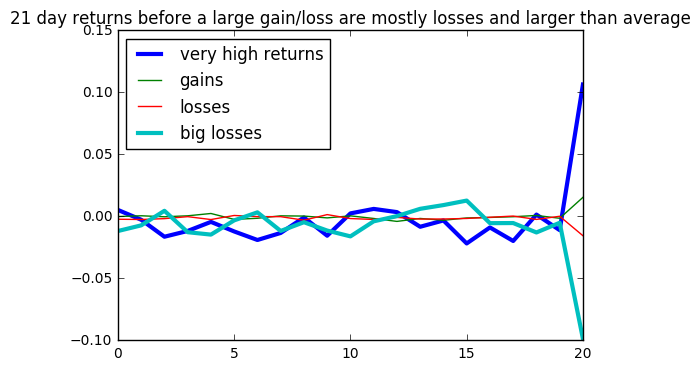

In [319]:
plt.title("21 day returns before a large gain/loss are mostly losses and larger than average")
plt.plot(high_avg, lw=3, label="very high returns")
plt.plot(slightlyHigh_avg, label="gains")
plt.plot(slightlyLow_avg, label="losses")
plt.plot(low_avg, lw=3, label='big losses')
plt.legend(loc='best')

plt.show()

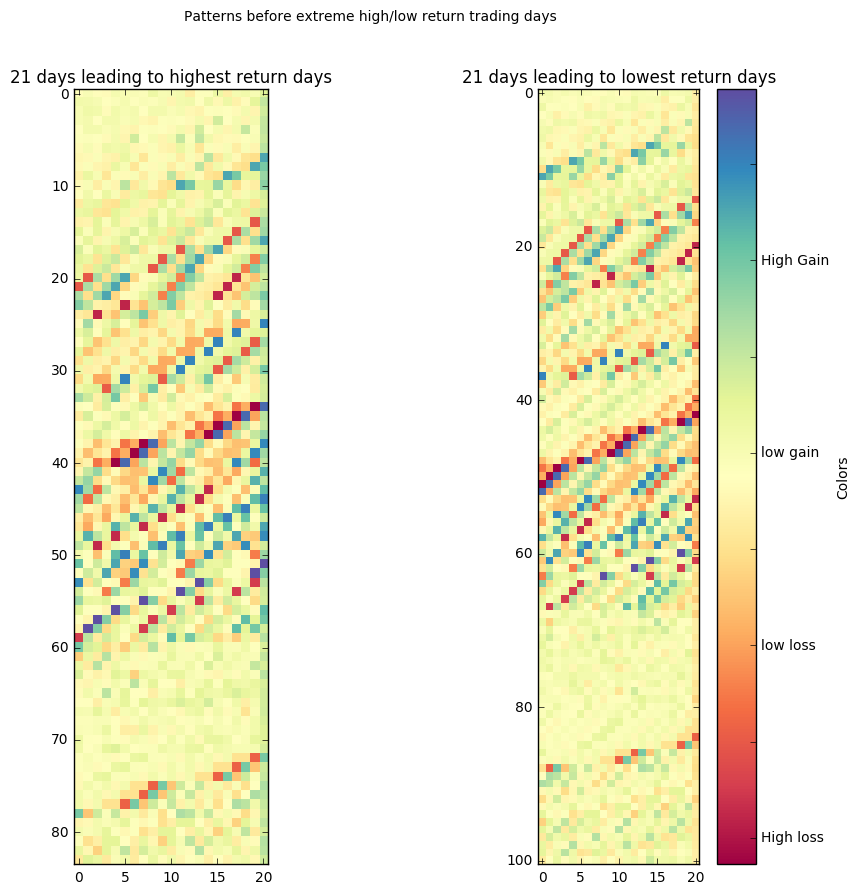

In [314]:
# heat maps of best worst trading days
plt.figure(figsize=(10, 10))
plt.suptitle("Patterns before extreme high/low return trading days")

plt.subplot(121)
map_best = plt.imshow(high_returns, cmap=plt.cm.Spectral, interpolation='nearest')
plt.title("21 days leading to highest return days")

plt.subplot(122)
map_worst = plt.imshow(low_returns, cmap=plt.cm.Spectral, interpolation='nearest')
plt.title("21 days leading to lowest return days")


cbar = plt.colorbar(map_best)
cbar.ax.set_yticklabels(['High loss', '', 'low loss', '', 'low gain', '', 'High Gain', ''])
cbar.set_label("Colors")

plt.show()

In [324]:
#Also let calculate the gain/loss using histogram

In [325]:
bac.head()

,Open,High,Low,Close,Adj Close,Volume,LogAdjClose,y,StationarySignal,LogAdjCloseShift,dx,GainLoss,i
Date,,,,,,,,,,,,,
2006-10-02,53.529999,53.680000,53.299999,53.619999,43.512402,7378600,3.773046,3.773046,39.739356,NaN,NaN,2,1
2006-10-03,53.630001,54.570000,53.570000,54.410000,44.153492,13591200,3.787672,3.771447,40.382045,0.014626,0.014626,3,2
2006-10-04,54.290001,54.849998,54.150002,54.820000,44.486210,12570700,3.795179,3.769847,40.716363,0.007507,0.007507,3,3
2006-10-05,54.560001,54.869999,54.270000,54.520000,44.242756,8653700,3.789692,3.768248,40.474508,-0.005488,-0.005488,2,4
2006-10-06,54.349998,54.470001,54.110001,54.240002,44.015545,8968900,3.784543,3.766649,40.248896,-0.005149,-0.005149,2,5


In [326]:
data['Adj Close'] = bac['Adj Close']
data['LogAdjClose'] = np.log(bac['Adj Close'])
# add volatility
# >1 increase over yesterday
# <1 decrease over yesterday
data['dx'] = data['Adj Close']/ data['Adj Close'].shift(1)
data = data.dropna(axis=0)

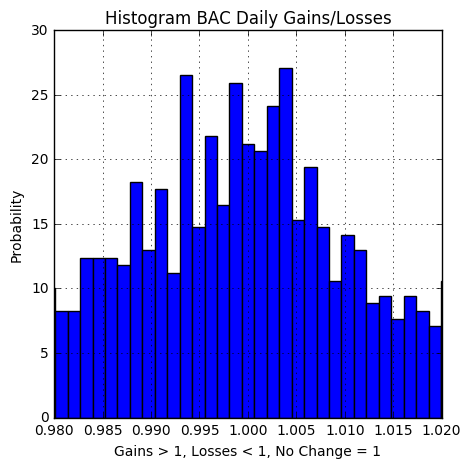

In [327]:
plt.figure(figsize=(5,5))
bins = 500
n, bins, patches = plt.hist(data['dx'], bins, normed=1)

plt.ylabel('Probability')
plt.title('Histogram BAC Daily Gains/Losses')
plt.grid(True)
plt.xlim(.98, 1.02)
plt.xlabel('Gains > 1, Losses < 1, No Change = 1')
plt.ylabel('Probability')
plt.title('Histogram BAC Daily Gains/Losses')
plt.grid(True)
plt.xlim(.98, 1.02)
plt.show()

In [329]:
#From above figure it is equally distributed. To see number of gains, loss we can simply calculate the number of 
#daily change. Such as

In [330]:
np.sum(data['dx']>1) #gains

622

In [331]:
np.sum(data['dx']<1) #Loss

685

In [332]:
np.sum(data['dx']==1) #No change

15

In [335]:
#Similar analysis can be done for remaining stocks. 

## III. 
Can you identify and explain the possible important market factors (including possible factors derived from market news) by using statistical and machine learning techniques? Please show details the way you choose the important factors.

In [3]:
#Market sentiment affect stock market besides the domestic/international news too. Here we will try to run 
# deep learning model along with the sentiment analysis data

In [4]:
#Utility for text processing

In [5]:
def load_text_data(filename = 'CombinedNews.csv', date_split = date(2014,12,31)):
	'''
		Load news from csv, group them and split in train/test set due to @date_split
	'''
	df = pd.read_csv(filename)
	df['Combined']=df.iloc[:,2:27].apply(lambda row: ''.join(str(row.values)), axis=1)

	train = df.loc[(pd.to_datetime(df["Date"]) <= date_split),['Label','Combined']]
	test = df.loc[(pd.to_datetime(df["Date"]) > date_split),['Label','Combined']]

	return train, test

def load_timeseries_csv(filename = 'bac1.csv', date_split = date(2014,12,31)):	
	'''
		Load time series from csv, taking adjustment close prices;
		transforming them into percentage of price change;
		split in train/test set due to @date_split
	'''
	data_original = pd.read_csv(filename)[::-1]

	train2 = data_original.loc[(pd.to_datetime(data_original["Date"]) <= date_split)]
	test2 = data_original.loc[(pd.to_datetime(data_original["Date"]) > date_split)]

	data_chng_train = train2.ix[:, 'Adj Close'].pct_change().dropna().tolist()
	data_chng_test = test2.ix[:, 'Adj Close'].pct_change().dropna().tolist()

	return data_chng_train, data_chng_test

def text_process(text):
    '''
    Takes in a string of text, then performs the following:
	    1. Tokenizes and removes punctuation
	    2. Removes  stopwords
	    3. Stems
	    4. Returns a list of the cleaned text
    '''
    if pd.isnull(text):
        return []
    # tokenizing
    tokenizer = RegexpTokenizer(r'\w+')
    text_processed=tokenizer.tokenize(text)
    
    # removing any stopwords
    text_processed = [word.lower() for word in text_processed if word.lower() not in stopwords.words('english')]
    
    # steming
    porter_stemmer = PorterStemmer()
    
    text_processed = [porter_stemmer.stem(word) for word in text_processed]
    
    try:
        text_processed.remove('b')
    except: 
        pass

    return " ".join(text_processed)


def text2sentences(train, test, save_train = 'train_text.p', save_test = 'test_text.p'):
	'''
		Transforming raw text into sentences, 
		if @save_train or @save_test is not None - saves pickles for further use
	'''
	train_text = []
	test_text = []
	for each in train['Combined']:
	    train_text.append(text_process(each))
	for each in test['Combined']:
	    test_text.append(text_process(each))

	if save_train != None: cPickle.dump(train_text, open(save_train, 'wb')) 
	if save_test != None: cPickle.dump(test_text, open(save_test, 'wb')) 

	return train_text, test_text


def text2vectors(train_text, test_text, embedding_size = 100, model_path = 'word2vec10.model'):
	'''
		Transforms sentences into sequences of word2vec vectors
		Returns train, test set and trained word2vec model
	'''
	data_for_w2v = []
	for text in train_text + test_text:
	    words = text.split(' ')
	    data_for_w2v.append(words)

	model = Word2Vec(data_for_w2v, size=embedding_size, window=5, min_count=1, workers=4)
	model.save(model_path)
	model = Word2Vec.load(model_path)

	train_text_vectors = [[model[x] for x in sentence.split(' ')] for sentence in train_text]
	test_text_vectors = [[model[x] for x in sentence.split(' ')] for sentence in test_text]

	train_text_vectors = [np.mean(x, axis=0) for x in train_text_vectors]
	test_text_vectors = [np.mean(x, axis=0) for x in test_text_vectors]

	return train_text_vectors, test_text_vectors, model


def split_train_test(data_chng_train, train_text_vectors, step, window, forecast):
	'''
		Splits textual and time series data into train or test dataset for hybrid model;
		objective y_i is percentage change of price movement for next day
	'''
	X_train, X_train_text, Y_train = [], [], []
	for i in range(0, len(data_chng_train), step): 
	    try:
	        x_i = data_chng_train[i:i+window]
	        y_i = data_chng_train[i+window+forecast]  

	        # text_average = np.mean(train_text_vectors[i:i+WINDOW], axis=0)
	        text_average = train_text_vectors[i:i+window]

	        last_close = x_i[-1]
	        next_close = y_i

	        if y_i > 0.:  #label is if future value is greater than past value put 1 else 0.
	            y_i = [1, 0]
	        else:
	            y_i = [0, 1] 

	    except Exception as e:
	        break

	    X_train.append(x_i)
	    X_train_text.append(text_average)
	    Y_train.append(y_i)

	X_train, X_train_text, Y_train = np.array(X_train), np.array(X_train_text), np.array(Y_train)
	return X_train, X_train_text, Y_train

In [390]:
def mymodel(window, embedding):
	model1 = Sequential()
	model1.add(Dense(64, input_dim=window, activity_regularizer=regularizers.l2(0.01)))
	model1.add(BatchNormalization())
	model1.add(LeakyReLU())
	model1.add(Dropout(0.75))
	model1.add(Dense(window, activity_regularizer=regularizers.l2(0.01)))
	model1.add(BatchNormalization())
	model1.add(LeakyReLU())

	model2 = Sequential()
	model2.add(LSTM(input_shape = (window, embedding,), output_dim=window, return_sequences=True, recurrent_dropout=0.75))   
	model2.add(LSTM(output_dim=window, return_sequences=False, recurrent_dropout=0.75))                               

	merged = Merge([model1, model2], mode='sum')

	final_model = Sequential()
	final_model.add(merged)

	final_model.add(Dense(16))
	final_model.add(BatchNormalization())
	final_model.add(LeakyReLU())

	final_model.add(Dense(2))
	final_model.add(Activation('softmax'))

	opt = Nadam(lr=0.002)
	final_model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

	return final_model


train, test = load_text_data()
data_chng_train, data_chng_test = load_timeseries_csv()

# train_text, test_text = transform_text2sentences(train, test)
train_text = cPickle.load(open('train_text.p', 'rb'))[1:]
test_text = cPickle.load(open('test_text.p', 'rb'))[1:]

train_text_vectors, test_text_vectors, model = text2vectors(train_text, test_text, 100)

X_train, X_train_text, Y_train = split_train_test(data_chng_train, train_text_vectors, 1, 10, 1)
X_test, X_test_text, Y_test = split_train_test(data_chng_test, test_text_vectors, 1, 10, 1)

final_model = mymodel(10, 100)

# seting callbacks for saving best models and scheduling learning rate
reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=50, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="test.hdf5", verbose=1, save_best_only=True)

# training the model
history = final_model.fit([X_train, X_train_text], Y_train, 
          nb_epoch = 500, 
          batch_size = 128, 
          verbose=1, 
          validation_data = ([X_test, X_test_text], Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:25: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:91: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:92: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
/usr/local/lib/python2.7/dist-packages/ipy

Train on 1599 samples, validate on 366 samples
Epoch 1/500
1408/1599 [=========================>....] - ETA: 0s - loss: 2.5922 - acc: 0.4766
Epoch 00001: val_loss improved from inf to 0.80425, saving model to test.hdf5
1599/1599 [==============================] - 2s 1ms/step - loss: 2.5403 - acc: 0.4822 - val_loss: 0.8042 - val_acc: 0.4945
Epoch 2/500
1408/1599 [=========================>....] - ETA: 0s - loss: 2.0352 - acc: 0.4723
Epoch 00002: val_loss improved from 0.80425 to 0.75287, saving model to test.hdf5
1599/1599 [==============================] - 1s 343us/step - loss: 1.9715 - acc: 0.4822 - val_loss: 0.7529 - val_acc: 0.5246
Epoch 3/500
1408/1599 [=========================>....] - ETA: 0s - loss: 1.5919 - acc: 0.4943
Epoch 00003: val_loss improved from 0.75287 to 0.73567, saving model to test.hdf5
1599/1599 [==============================] - 1s 344us/step - loss: 1.5540 - acc: 0.4903 - val_loss: 0.7357 - val_acc: 0.5273
Epoch 4/500
1408/1599 [=========================>....] -

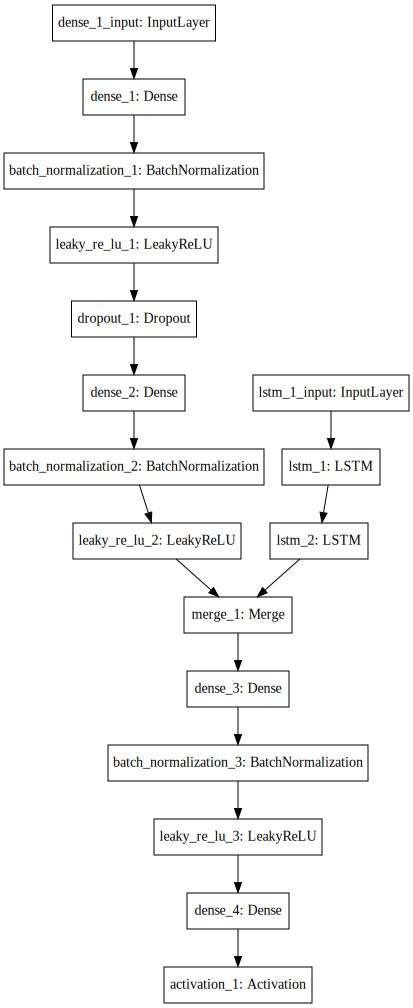

In [11]:
#plot_model(final_model, to_file='model.png', show_shapes=True)
SVG(model_to_dot(final_model).create(prog='dot', format='svg'))

In [76]:
plot_model(model, to_file='model_cnn.png', show_shapes=True)

AttributeError: 'ARMA' object has no attribute 'layers'

In [391]:
# load weights
#final_model.load_weights("test.hdf5")
#final_model.compile(optimizer=Nadam(lr=0.002), loss='categorical_crossentropy', metrics=['accuracy'])

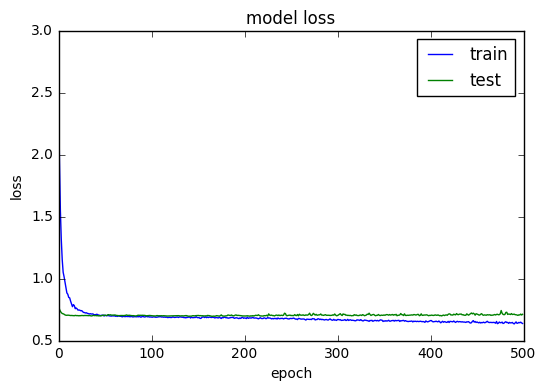

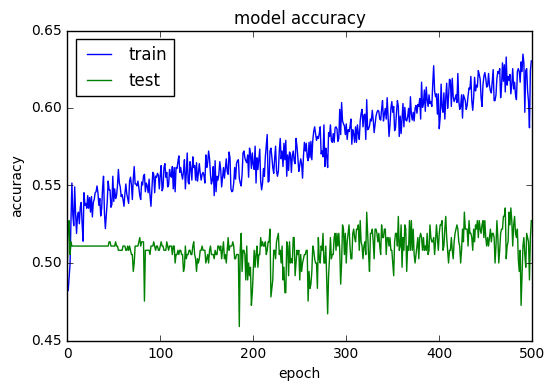

In [392]:
# plotting performance
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [393]:
X_train[:5]

array([[ 0.00409306, -0.01187199, -0.00940606,  0.00719414,  0.00378538,
        -0.01548133, -0.0113978 ,  0.00606949,  0.00111937,  0.01730936],
       [-0.01187199, -0.00940606,  0.00719414,  0.00378538, -0.01548133,
        -0.0113978 ,  0.00606949,  0.00111937,  0.01730936, -0.02079535],
       [-0.00940606,  0.00719414,  0.00378538, -0.01548133, -0.0113978 ,
         0.00606949,  0.00111937,  0.01730936, -0.02079535,  0.00233792],
       [ 0.00719414,  0.00378538, -0.01548133, -0.0113978 ,  0.00606949,
         0.00111937,  0.01730936, -0.02079535,  0.00233792,  0.00785426],
       [ 0.00378538, -0.01548133, -0.0113978 ,  0.00606949,  0.00111937,
         0.01730936, -0.02079535,  0.00233792,  0.00785426,  0.018489  ]])

In [394]:
train_text[0]

u'wont america nato help us wont help us help iraq b bush put foot georgian conflict b jewish georgian minist thank isra train fend russia b georgian armi flee disarray russian advanc gori abandon russia without shot fire b olymp open ceremoni firework fake b mossad fraudul new zealand passport iraq b russia anger isra militari sale georgia b american citizen live ossetia blame u georgian leader genocid innoc peopl b welcom world war iv high definit b georgia move mistak monument proport b russia press deeper georgia u say regim chang goal b abhinav bindra win first ever individu olymp gold medal india b u ship head arctic defin territori b driver jerusalem taxi station threaten quit rather work new boss arab b french team stun phelp 4x100m relay team b israel us behind georgian aggress b believ tv neither russian georgian much victim b riot still go montreal canada polic murder boy saturday b china overtak us largest manufactur b war south ossetia pic b isra physician group condemn st

In [395]:
#predict class
Y_test_prob = final_model.predict([X_test, X_test_text])
Y_test_predict = Y_test_prob.argmax(axis=-1)
Y_test_predict

array([0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1,
       0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1,
       1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1,
       0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0,

In [396]:
metrics.roc_auc_score(Y_test.argmax(axis=-1), Y_test_prob[:,1])

0.52188330893556

In [397]:
metrics.confusion_matrix(Y_test.argmax(axis=-1), Y_test_predict)

array([[131,  56],
       [117,  62]])

In [398]:
metrics.accuracy_score(Y_test.argmax(axis=-1), Y_test_predict)

0.5273224043715847

In [399]:
target_names = ['class 0', 'class 1']
print(metrics.classification_report(Y_test.argmax(axis=-1), Y_test_predict, target_names=target_names) )

             precision    recall  f1-score   support

    class 0       0.53      0.70      0.60       187
    class 1       0.53      0.35      0.42       179

avg / total       0.53      0.53      0.51       366



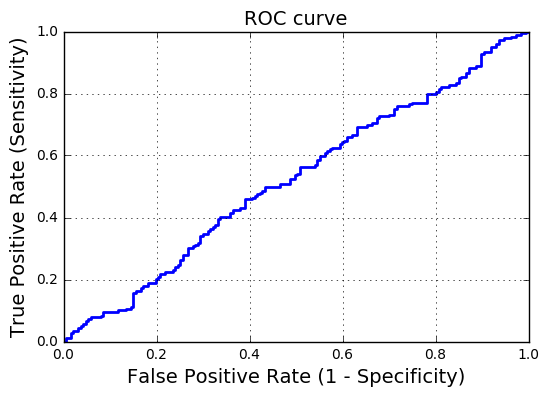

In [400]:
#ROC curve
# IMPORTANT: first argument is true values, second argument is predicted probabilities
fpr, tpr, thresholds = metrics.roc_curve(Y_test.argmax(axis=-1), Y_test_prob[:,1])
plt.plot(fpr, tpr, lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve',fontsize=14)
plt.xlabel('False Positive Rate (1 - Specificity)',fontsize=14) #fontweight='bold'
plt.ylabel('True Positive Rate (Sensitivity)',fontsize=14)
plt.grid(True)

In [405]:
#As we see above we use sentiment text+stock return to do the prediction. Here the label are if future value is greater
#than current value then put it as 1 else 0. The classification accuracy we got is around .53 which is better than 
#random chance. Hence I think the sentiment/news are the important market factor for prediction.

# IV. 
Is it possible to develop a predictive model to predict the returns from the portfolio (consisting of the stocks you have chosen)? If possible,

a. What are the possible features and algorithms you would consider (please provide reasoning)?<br>
b. Can you develop/test/validate an end to end predictive model?<br>
c. Can you make prediction on new data?<br>
d. Can you explain/interpret the predictions?<br>

In [10]:
#Yes it is possible to develop the predictive model 

In [11]:
bac.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-10-02,53.529999,53.680000,53.299999,53.619999,43.512402,7378600
2006-10-03,53.630001,54.570000,53.570000,54.410000,44.153492,13591200
2006-10-04,54.290001,54.849998,54.150002,54.820000,44.486210,12570700
2006-10-05,54.560001,54.869999,54.270000,54.520000,44.242756,8653700
2006-10-06,54.349998,54.470001,54.110001,54.240002,44.015545,8968900


In [12]:
# add volatility
# >1 increase over yesterday
# <1 decrease over yesterday
bac['dx'] = bac['Adj Close']/ bac['Adj Close'].shift(1)
bac = bac.dropna(axis=0)

/usr/local/lib/python2.7/dist-packages/pandas/core/computation/check.py:17: UserWarning: The installed version of numexpr 2.2.2 is not supported in pandas and will be not be used
The minimum supported version is 2.4.6

  ver=ver, min_ver=_MIN_NUMEXPR_VERSION), UserWarning)


In [13]:
bac.head()

,Open,High,Low,Close,Adj Close,Volume,dx
Date,,,,,,,
2006-10-03,53.630001,54.570000,53.570000,54.410000,44.153492,13591200,1.014734
2006-10-04,54.290001,54.849998,54.150002,54.820000,44.486210,12570700,1.007535
2006-10-05,54.560001,54.869999,54.270000,54.520000,44.242756,8653700,0.994527
2006-10-06,54.349998,54.470001,54.110001,54.240002,44.015545,8968900,0.994864
2006-10-09,54.080002,54.540001,54.049999,54.509998,44.234634,5886000,1.004978


In [14]:
def shuffle_data(a, b):
    # courtsey http://stackoverflow.com/users/190280/josh-bleecher-snyder
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

def createTrainTest(X, y, percentage=0.8):
    X_train = X[0:int(len(X) * percentage)]
    Y_train = y[0:int(len(y) * percentage)]
    
    X_train, Y_train = shuffle_data(X_train, Y_train)

    X_test = X[int(len(X) * percentage):]
    Y_test = y[int(len(X) * percentage):]

    return X_train, X_test, Y_train, Y_test

In [15]:
openp = bac.ix[:, 'Open'].tolist()
highp = bac.ix[:, 'High'].tolist()
lowp = bac.ix[:, 'Low'].tolist()
closep = bac.ix[:, 'Adj Close'].tolist()
volumep = bac.ix[:, 'Volume'].tolist()

WINDOW = 30
EMB_SIZE = 5
STEP = 1
FORECAST = 1

X, Y = [], []
for i in range(0, len(bac), STEP): 
    try:
        o = openp[i:i+WINDOW]
        h = highp[i:i+WINDOW]
        l = lowp[i:i+WINDOW]
        c = closep[i:i+WINDOW]
        v = volumep[i:i+WINDOW]

        o = (np.array(o) - np.mean(o)) / np.std(o)
        h = (np.array(h) - np.mean(h)) / np.std(h)
        l = (np.array(l) - np.mean(l)) / np.std(l)
        c = (np.array(c) - np.mean(c)) / np.std(c)
        v = (np.array(v) - np.mean(v)) / np.std(v)

        x_i = closep[i:i+WINDOW]
        y_i = closep[i+WINDOW+FORECAST]  

        last_close = x_i[-1]
        next_close = y_i

        if last_close < next_close:
            y_i = [1, 0]
        else:
            y_i = [0, 1] 

        x_i = np.column_stack((o, h, l, c, v))

    except Exception as e:
        break

    X.append(x_i)
    Y.append(y_i)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  if __name__ == '__main__':


In [77]:
len(X), X[0].shape

(1291, (30, 5))

In [78]:
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = createTrainTest(X, Y)

X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))

model = Sequential()
model.add(Convolution1D(input_shape = (WINDOW, EMB_SIZE),
                        nb_filter=16,
                        filter_length=3,
                        border_mode='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Convolution1D(nb_filter=8,
                        filter_length=3,
                        border_mode='same'))
model.add(BatchNormalization())
model.add(LeakyReLU())
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(64))
model.add(BatchNormalization())
model.add(LeakyReLU())


model.add(Dense(2))
model.add(Activation('softmax'))

opt = Nadam(lr=0.002)

reduce_lr = ReduceLROnPlateau(monitor='val_acc', factor=0.9, patience=30, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(filepath="bac_cnn.hdf5", verbose=1, save_best_only=True)


model.compile(optimizer=opt, 
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, 
          nb_epoch = 100, 
          batch_size = 128, 
          verbose=1, 
          validation_data=(X_test, Y_test),
          callbacks=[reduce_lr, checkpointer],
          shuffle=True)

model.load_weights("bac_cnn.hdf5")
pred = model.predict(np.array(X_test))


C = confusion_matrix([np.argmax(y) for y in Y_test], [np.argmax(y) for y in pred])

print C / C.astype(np.float).sum(axis=1)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:11: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(input_shape=(30, 5), padding="same", filters=16, kernel_size=3)`
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: UserWarning: Update your `Conv1D` call to the Keras 2 API: `Conv1D(padding="same", kernel_size=3, filters=8)`
/usr/local/lib/python2.7/dist-packages/keras/models.py:944: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Train on 1032 samples, validate on 259 samples
Epoch 1/100
 896/1032 [=========================>....] - ETA: 0s - loss: 0.8926 - acc: 0.4944
Epoch 00001: val_loss improved from inf to 0.69053, saving model to bac_cnn.hdf5
1032/1032 [==============================] - 2s 2ms/step - loss: 0.8926 - acc: 0.4932 - val_loss: 0.6905 - val_acc: 0.5753
Epoch 2/100
 896/1032 [=========================>....] - ETA: 0s - loss: 0.7867 - acc: 0.5190
Epoch 00002: val_loss did not improve
1032/1032 [==============================] - 0s 89us/step - loss: 0.7910 - acc: 0.5155 - val_loss: 0.7110 - val_acc: 0.5058
Epoch 3/100
 896/1032 [=========================>....] - ETA: 0s - loss: 0.7623 - acc: 0.5301
Epoch 00003: val_loss did not improve
1032/1032 [==============================] - 0s 86us/step - loss: 0.7726 - acc: 0.5194 - val_loss: 0.7014 - val_acc: 0.4942
Epoch 4/100
 896/1032 [=========================>....] - ETA: 0s - loss: 0.7400 - acc: 0.5279
Epoch 00004: val_loss did not improve
1032/1032 [

In [79]:
plot_model(model, to_file='model_cnn.png', show_shapes=True)

In [34]:
#predict class
Y_test_prob = model.predict(X_test)
Y_test_predict = Y_test_prob.argmax(axis=-1)
Y_test_predict

array([0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1,
       1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [35]:
metrics.roc_auc_score(Y_test.argmax(axis=-1), Y_test_prob[:,1])

0.5363083416087389

In [36]:
metrics.confusion_matrix(Y_test.argmax(axis=-1), Y_test_predict)

array([[ 26,  80],
       [ 34, 118]])

In [37]:
metrics.accuracy_score(Y_test.argmax(axis=-1), Y_test_predict)

0.5581395348837209

In [38]:
target_names = ['class 0', 'class 1']
print(metrics.classification_report(Y_test.argmax(axis=-1), Y_test_predict, target_names=target_names) )

             precision    recall  f1-score   support

    class 0       0.43      0.25      0.31       106
    class 1       0.60      0.78      0.67       152

avg / total       0.53      0.56      0.53       258



In [80]:
#ROC curve
# IMPORTANT: first argument is true values, second argument is predicted probabilities
"""
fpr, tpr, thresholds = metrics.roc_curve(Y_test.argmax(axis=-1), Y_test_prob[:,1])
plt.plot(fpr, tpr, lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.title('ROC curve',fontsize=14)
plt.xlabel('False Positive Rate (1 - Specificity)',fontsize=14) #fontweight='bold'
plt.ylabel('True Positive Rate (Sensitivity)',fontsize=14)
plt.grid(True)
"""

"\nfpr, tpr, thresholds = metrics.roc_curve(Y_test.argmax(axis=-1), Y_test_prob[:,1])\nplt.plot(fpr, tpr, lw=2)\nplt.xlim([0.0, 1.0])\nplt.ylim([0.0, 1.0])\nplt.title('ROC curve',fontsize=14)\nplt.xlabel('False Positive Rate (1 - Specificity)',fontsize=14) #fontweight='bold'\nplt.ylabel('True Positive Rate (Sensitivity)',fontsize=14)\nplt.grid(True)\n"

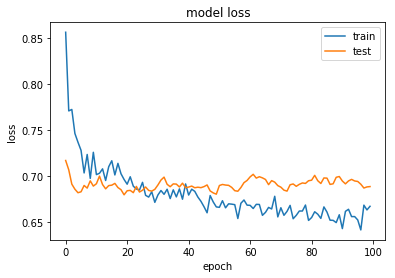

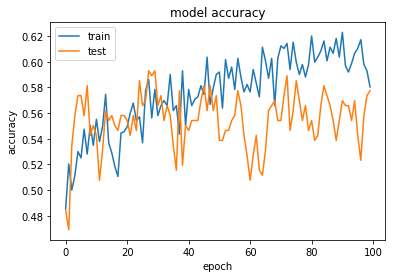

In [40]:
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

plt.figure()
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='best')
plt.show()

In [17]:
#LSTM

In [18]:
X, Y = np.array(X), np.array(Y)
X_train, X_test, Y_train, Y_test = createTrainTest(X, Y)

In [19]:
X_train.shape, Y_train.shape

((1032, 30, 5), (1032, 2))

In [20]:
#X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], EMB_SIZE))
#X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], EMB_SIZE))

In [21]:
X_train.shape

(1032, 30, 5)

<keras.engine.topology.InputLayer object at 0x7fa24c329f90> (None, 30, 5)
<keras.layers.recurrent.LSTM object at 0x7fa24c329f50> (None, 30, 10)
<keras.layers.recurrent.LSTM object at 0x7fa24c336090> (None, 10)
<keras.layers.core.Dense object at 0x7fa24c336250> (None, 64)
<keras.layers.advanced_activations.LeakyReLU object at 0x7fa24c0963d0> (None, 64)
<keras.layers.core.Dropout object at 0x7fa22c4f8710> (None, 64)
<keras.layers.core.Dense object at 0x7fa22c4f8850> (None, 2)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:30: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 1032 samples, validate on 259 samples
Epoch 1/100
1024/1032 [============================>.] - ETA: 0s - loss: 0.7264 - acc: 0.5244
Epoch 00001: val_loss improved from inf to 0.68006, saving model to model.hdf5
1032/1032 [==============================] - 2s 2ms/step - loss: 0.7259 - acc: 0.5252 - val_loss: 0.6801 - val_acc: 0.5869
Epoch 2/100
1024/1032 [============================>.] - ETA: 0s - loss: 0.7043 - acc: 0.5117
Epoch 00002: val_loss did not improve
1032/1032 [==============================] - 1s 514us/step - loss: 0.7045 - acc: 0.5126 - val_loss: 0.6988 - val_acc: 0.4131
Epoch 3/100
1024/1032 [============================>.] - ETA: 0s - loss: 0.7034 - acc: 0.5156
Epoch 00003: val_loss did not improve
1032/1032 [==============================] - 1s 502us/step - loss: 0.7036 - acc: 0.5145 - val_loss: 0.6980 - val_acc: 0.4131
Epoch 4/100
1024/1032 [============================>.] - ETA: 0s - loss: 0.7046 - acc: 0.4971
Epoch 00004: val_loss did not improve
1032/1032 [

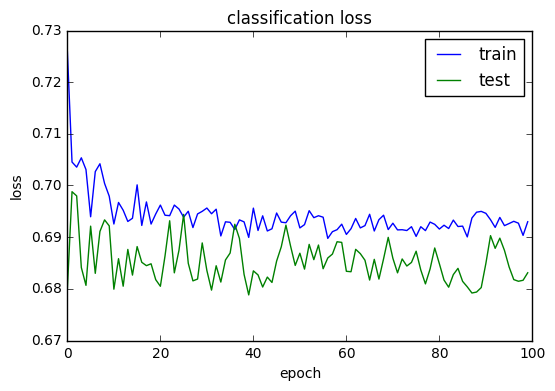

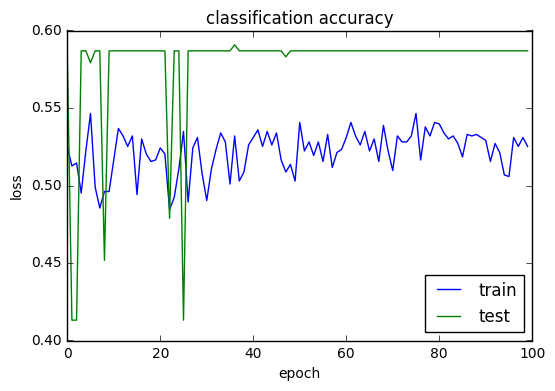

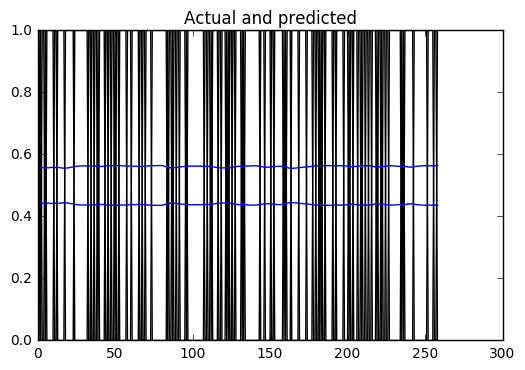

0.24286733663856241
0.489120049193559
inf


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:71: RuntimeWarning: divide by zero encountered in divide


In [81]:
main_input = Input(shape=(30, 5), name='ts_input')
lstm1 = LSTM(10, return_sequences=True, recurrent_dropout=0.25, dropout=0.25, bias_initializer='ones')(main_input)
lstm1 = LSTM(10, return_sequences=False, recurrent_dropout=0.25, dropout=0.25, bias_initializer='ones')(lstm1)
#lstm1 = Flatten()(lstm1)

x2 = Dense(64)(lstm1)
x2 = LeakyReLU()(x2)
x2 = Dropout(0.5)(x2)
x2 = Dense(2, activation = 'softmax', name = 'class')(x2)


final_model = Model(inputs=[main_input], outputs=[x2])
opt = Nadam(lr=0.002, clipnorm = 0.5)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=50, min_lr=0.000001, verbose=1)
checkpointer = ModelCheckpoint(monitor='val_loss', filepath="model.hdf5", verbose=1, save_best_only=True)
final_model.compile(optimizer=opt, loss={'class': 'binary_crossentropy'}, metrics = {'class': 'accuracy'})


for layer in final_model.layers:
    print layer, layer.output_shape


try:
	history = final_model.fit(X_train, Y_train, 
	              nb_epoch = 100, 
	              batch_size = 256, 
	              verbose=1, 
	              validation_data=(X_test, Y_test),
	              callbacks=[reduce_lr, checkpointer],
	              shuffle=True)
   

	plt.figure()
	plt.plot(history.history['loss'])
	plt.plot(history.history['val_loss'])
	plt.title('classification loss')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='best')
	plt.show()

	plt.figure()
	plt.plot(history.history['acc'])
	plt.plot(history.history['val_acc'])
	plt.title('classification accuracy')
	plt.ylabel('loss')
	plt.xlabel('epoch')
	plt.legend(['train', 'test'], loc='best')
	plt.show()


except Exception as e:
    print e

finally:
    final_model.load_weights("model.hdf5")
    pred = final_model.predict(X_test)

    predicted = pred
    original = Y_test

    plt.title('Actual and predicted')
    plt.legend(loc='best')
    plt.plot(original, color='black', label = 'Original data')
    plt.plot(pred, color='blue', label = 'Predicted data')
    plt.show()


    print np.mean(np.square(predicted - original))
    print np.mean(np.abs(predicted - original))
    print np.mean(np.abs((original - predicted) / original))


In [82]:
plot_model(final_model, to_file='model_lstm.png', show_shapes=True)

In [47]:
#predicted

In [48]:
#Y_test

In [49]:
#bac.tail()

In [83]:
#Deep Q Learning

In [34]:
# constants
# stock, money, shares
budget = 1000.              # dollars
n_stocks = 0                # starting shares
stock = 'BAC'
start_date = '2006-10-03'
end_date = '2011-12-29'

# network constants
history = 20                # about 20 trading days/month       
n_hidden1 = history

def plot_prices(prices):

    plt.title('Opening stock prices')
    plt.xlabel('Day')
    plt.ylabel('Price $')
    plot.plot(prices)
    plt.savefig('prices.png')

In [35]:
class DecisionPolicy:
    
    def select_action(self, current_state):
        pass

    def update_Q(self, state, action, reward, next_state):
        pass 

class RandomDecisionPolicy(DecisionPolicy):

    def __init__(self, actions):
        self.actions = actions

    def select_action(self, current_state, step):
        action = self.actions[random.randint(0, len(self.actions) - 1)]
        return action 

class QLearningDecisionPolicy(DecisionPolicy):

    def __init__(self, actions, n_input):
        
        self.epsilon = 0.8      # probability of chosing best action over random action
        self.gamma = 0.01      # time discount for past data
        self.actions = actions
        learning_rate = 0.01
        n_output = len(actions)

        self.x = tf.placeholder(tf.float32, [None, n_input])
        self.y = tf.placeholder(tf.float32, [n_output])
        
        W1 = tf.Variable(tf.random_normal([n_input, n_hidden1]))
        b1 = tf.Variable(tf.constant(0.1, shape=[n_hidden1]))
        h1 = tf.nn.relu(tf.matmul(self.x, W1) + b1)

        W2 = tf.Variable(tf.random_normal([n_hidden1, n_output]))
        b2 = tf.Variable(tf.constant(0.1, shape=[n_output]))
        self.q = tf.nn.relu(tf.matmul(h1, W2) + b2)

        loss = tf.square(self.y - self.q)
        self.train_op = tf.train.AdagradOptimizer(learning_rate).minimize(loss)
        self.sess = tf.Session()
        self.sess.run(tf.initialize_all_variables())


    def select_action(self, current_state, step):

        threshold = min(self.epsilon, step / 1000.)

        if random.random() < threshold:
            action_q_vals = self.sess.run(self.q, {self.x: current_state})
            action_idx = np.argmax(action_q_vals)
            action = self.actions[action_idx]
        else:
            action = self.actions[random.randint(0, len(self.actions) - 1)]
            
        return action


    def update_Q(self, state, action, reward, next_state):

        action_q_vals = self.sess.run(self.q, {self.x: next_state})
        next_action_q_vals = self.sess.run(self.q, {self.x: next_state})
        next_action_idx = np.argmax(next_action_q_vals)
        action_q_vals[0, next_action_idx] = reward + self.gamma * next_action_q_vals[0, next_action_idx]
        action_q_vals = np.squeeze(np.asarray(action_q_vals))
        
        self.sess.run(self.train_op, {self.x: state, self.y: action_q_vals})

In [36]:
def run_simulation(policy, initial_budget, initial_number_stocks, prices, history, debug=False):
    budget = initial_budget
    n_stocks = initial_number_stocks
    share_value = 0
    plan = []
    transitions = list()

    for i in range(len(prices) - history - 1):
        current_state = np.asmatrix(np.hstack((prices[i:i+history], budget, n_stocks)))
        current_portfolio = budget + n_stocks + share_value
        action = policy.select_action(current_state, i)
        share_value = float(prices[i + history + 1])

        if action == 'Buy' and budget >= share_value:
            budget -= share_value 
            n_stocks += 1

        elif action == 'Sell' and n_stocks > 0:
            budget += share_value
            n_stocks -= 1 

        else:
            action == 'Hold'

        new_portfolio = budget + n_stocks * share_value
        reward = new_portfolio - current_portfolio
        next_state = np.asmatrix(np.hstack((prices[i+1:i+history+1], budget, n_stocks)))
        transitions.append((current_state, action, reward, next_state))

        policy.update_Q(current_state, action, reward, next_state)
        plan.append((action, share_value))
        
    portfolio = budget + n_stocks * share_value
    return portfolio, plan

def run_simulations(policy, budget, n_stocks, prices, history):
    n_tries = 50
    final_portfolios = list()
    final_policies = list()
    final_plans = list()

    for i in range(n_tries):
        final_portfolio, final_plan = run_simulation(policy, budget, n_stocks, prices, history)
        final_portfolios.append(final_portfolio)
        final_plans.append(final_plan)

    avg, std = np.mean(final_portfolios), np.std(final_portfolios)
    return avg, std, final_plans


In [38]:
# run_simulation
start_end_date = np.logical_and(bac.index>=start_date, bac.index <= end_date)
prices = bac[start_end_date]['Open']
prices.head()

Date
2006-10-03    53.630001
2006-10-04    54.290001
2006-10-05    54.560001
2006-10-06    54.349998
2006-10-09    54.080002
Name: Open, dtype: float64

In [39]:
history

20

In [40]:
actions = ['Buy', 'Sell', 'Hold']
policy = RandomDecisionPolicy(actions)

budget = 1000.
n_stocks = 0
n_hidden1 = history

avg, std, plans = run_simulations(policy, budget, n_stocks, prices, history)

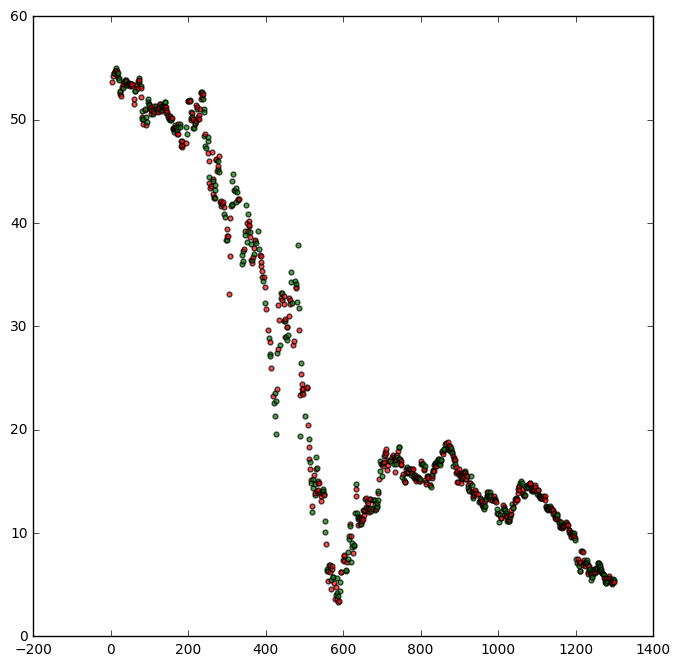

In [41]:
last_plan = plans[len(plans) -1]
prices = prices[history:-1]

fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(1,1,1)
d = 0

#plt.title("Random policy")
#subtitle = 'Buys are green, Sells are red, avg return on $1000   = %d over %d trading days' % (int(avg), len(last_plan))
for p in last_plan:
    action, price = p 
    d += 1
   
    if action == 'Buy': 
        ax.scatter(d, price, c='green', alpha=0.7, s=12)
    if action == 'Sell': 
        ax.scatter(d, price, c='red', alpha=0.7, s=12)

In [46]:
last_plan

[('Hold', 54.150002),
 ('Hold', 53.360001),
 ('Hold', 53.549999),
 ('Sell', 53.68),
 ('Sell', 54.220001),
 ('Hold', 54.400002),
 ('Hold', 54.52),
 ('Buy', 54.509998),
 ('Buy', 54.57),
 ('Hold', 54.549999),
 ('Hold', 54.77),
 ('Sell', 54.73),
 ('Hold', 54.849998),
 ('Sell', 54.849998),
 ('Buy', 55.040001),
 ('Sell', 54.68),
 ('Sell', 54.369999),
 ('Buy', 54.560001),
 ('Hold', 53.919998),
 ('Buy', 54.060001),
 ('Buy', 54.02),
 ('Buy', 53.830002),
 ('Buy', 52.5),
 ('Sell', 52.66),
 ('Buy', 52.75),
 ('Hold', 52.619999),
 ('Sell', 52.299999),
 ('Hold', 51.860001),
 ('Hold', 52.450001),
 ('Sell', 53.200001),
 ('Buy', 53.099998),
 ('Hold', 53.220001),
 ('Sell', 53.470001),
 ('Hold', 53.419998),
 ('Sell', 53.700001),
 ('Buy', 53.889999),
 ('Sell', 53.639999),
 ('Hold', 53.400002),
 ('Sell', 53.880001),
 ('Buy', 53.799999),
 ('Hold', 53.650002),
 ('Buy', 53.400002),
 ('Buy', 53.330002),
 ('Sell', 53.59),
 ('Hold', 53.459999),
 ('Sell', 53.599998),
 ('Hold', 53.259998),
 ('Sell', 53.5),
 ('Sell'

In [42]:
# compute how well we did
years = len(last_plan) / 251
earnings = (avg - budget) / budget * 100.0
net = avg - budget 
roi = np.power((budget + net/budget), (1./years)) 

In [43]:
# feedback to user
print("Avg earnings", avg)
print("Std", std)
print("Years invested", years)
print("Total earnings %.2lf%%" % (earnings) )
print("Yearly ROI ~ %.2lf%%" %(roi) )

('Avg earnings', 539.43160472)
('Std', 190.41361163259222)
('Years invested', 5)
Total earnings -46.06%
Yearly ROI ~ 3.98%


In [51]:
#ARIMA model

In [56]:
bac.tail()

,Open,High,Low,Close,Adj Close,Volume,dx,returns
Date,,,,,,,,
2011-12-23,5.54,5.63,5.47,5.60,5.282220,190712000,1.023766,0.023215
2011-12-27,5.55,5.58,5.46,5.48,5.169029,158575400,0.978571,-0.021898
2011-12-28,5.45,5.46,5.27,5.29,4.989810,146104500,0.965328,-0.035917
2011-12-29,5.29,5.48,5.28,5.46,5.150163,168098500,1.032136,0.031136
2011-12-30,5.39,5.58,5.37,5.56,5.244491,176441000,1.018316,0.017986


In [54]:
# create target --- let's try Nasdaq value 1 day change
bac['returns'] = (bac['Adj Close'] - bac['Adj Close'].shift(1)) / bac['Adj Close']

# remove nan row from target creation
data = bac.dropna()

                            Results: ARMA
Model:              ARMA             BIC:                 -4204.4115
Dependent Variable: returns          Log-Likelihood:      2131.0    
Date:               2018-02-18 14:23 Scale:               1.0000    
No. Observations:   1321             Method:              css-mle   
Df Model:           7                Sample:              10-04-2006
Df Residuals:       1314                                  12-30-2011
Converged:          1.0000           S.D. of innovations: 0.048     
AIC:                -4245.9006       HQIC:                -4230.346 
---------------------------------------------------------------------
                  Coef.   Std.Err.     t     P>|t|    [0.025   0.975]
---------------------------------------------------------------------
ar.L1.returns     0.1386    0.2635   0.5258  0.5991  -0.3779   0.6550
ar.L2.returns    -0.0295    0.1717  -0.1719  0.8636  -0.3661   0.3070
ar.L3.returns    -0.0608    0.0320  -1.9010  0.0575  -0.

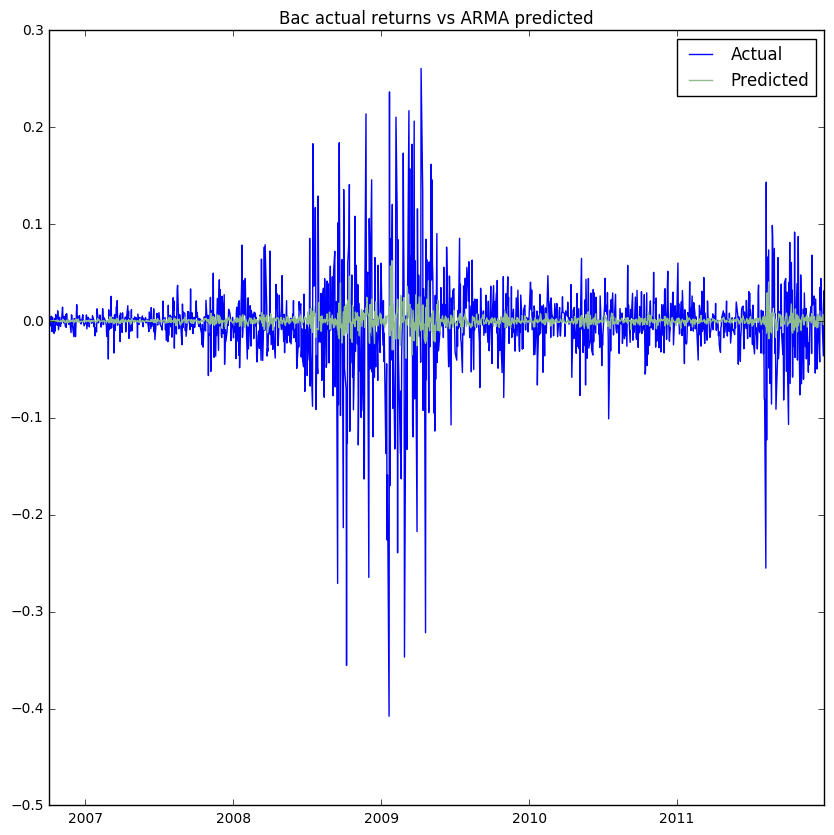

In [60]:
# looks okay, p-value is close to zero
# ARMA Auto regressive moving average
# p is the autoregressive count
# q is the moving average count
# let pandas select best p, q
#print (arma_order_select_ic(data.returns, ic=['aic', 'bic'], trend='nc',
#                            max_ar=5, max_ma=5, fit_kw={'method': 'css-mle'}))

# returns 5,2 and 0, 1
ts = data.returns
model = ARMA(ts, order=(5,2))
results = model.fit(trend='nc', method='css-mle', disp=-1)
print(results.summary2())
predicted = results.predict('2006-10-04', '2011-12-29')


plt.figure(figsize=(10, 10))
plt.title("Bac actual returns vs ARMA predicted")
plt.plot(data['returns'], c='blue', label='Actual')
plt.plot(predicted, c='darkseagreen', label='Predicted')
plt.legend(loc='best')
plt.show()

                           Results: ARIMA
Model:              ARIMA            BIC:                 -4182.7615
Dependent Variable: D.returns        Log-Likelihood:      2123.7    
Date:               2018-02-18 14:23 Scale:               1.0000    
No. Observations:   1320             Method:              css-mle   
Df Model:           8                Sample:              10-05-2006
Df Residuals:       1312                                  12-30-2011
Converged:          1.0000           S.D. of innovations: 0.048     
AIC:                -4229.4300       HQIC:                -4211.933 
---------------------------------------------------------------------
                   Coef.   Std.Err.     t     P>|t|    [0.025  0.975]
---------------------------------------------------------------------
const             -0.0000    0.0000  -0.2849  0.7758  -0.0000  0.0000
ar.L1.D.returns   -0.4955       nan      nan     nan      nan     nan
ar.L2.D.returns    0.0436    0.0340   1.2806  0.2005  -0

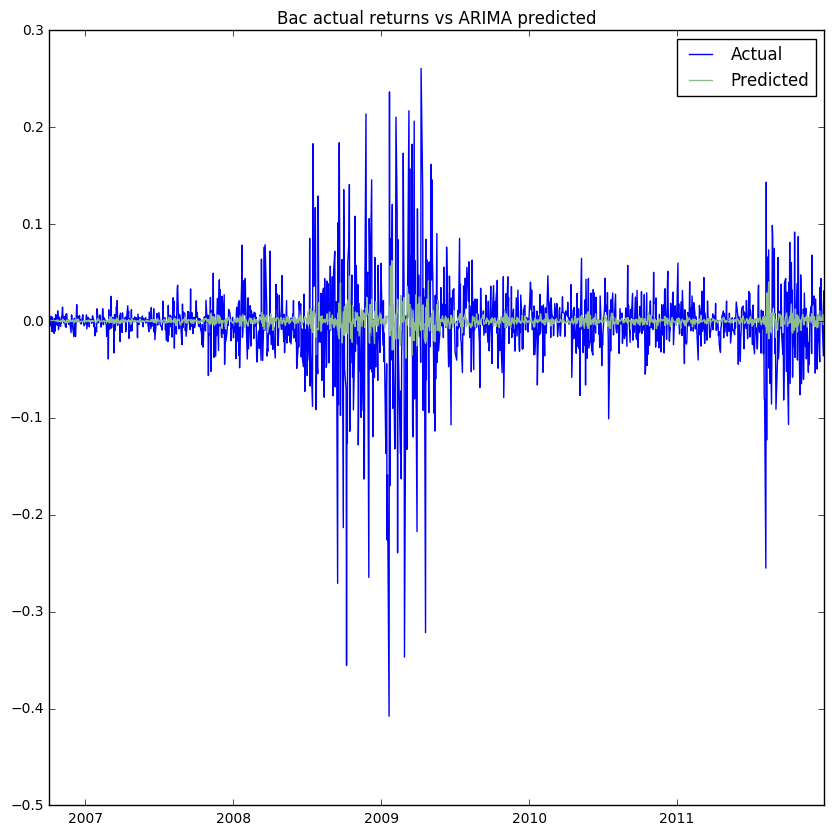

In [61]:
model_arima = ARIMA(ts, order=(5, 1, 2))
results_arima = model_arima.fit(disp=-1, transparams=True)
print(results_arima.summary2())
predicted = results.predict('2006-10-04', '2011-12-29')


plt.figure(figsize=(10, 10))
plt.title("Bac actual returns vs ARIMA predicted")
plt.plot(data['returns'], c='blue', label='Actual')
plt.plot(predicted, c='darkseagreen', label='Predicted')
plt.legend(loc='best')
plt.show()

In [69]:
bac.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-10-02,53.529999,53.680000,53.299999,53.619999,43.512402,7378600
2006-10-03,53.630001,54.570000,53.570000,54.410000,44.153492,13591200
2006-10-04,54.290001,54.849998,54.150002,54.820000,44.486210,12570700
2006-10-05,54.560001,54.869999,54.270000,54.520000,44.242756,8653700
2006-10-06,54.349998,54.470001,54.110001,54.240002,44.015545,8968900


In [70]:
#Regression

In [71]:
data = bac[['Open']]
data['Open'] = pd.to_numeric(data['Open'], errors='coerce')
data['Volatility'] = data['Open'] - data['Open'].shift(1)
data = data.dropna()

bac_standard = data.loc[data.index < '2009-10-04']
bacc = data.loc[data.index > '2009-10-04']

print(len(bac_standard), len(bacc))

(756, 566)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [72]:
x1 = np.arange(1, len(bacc)+ 1)
x2 = x1 **2
x3 = x1 **3
x4 = x1 **4     # best so far

x = [x1, x2, x3, x4]
x = np.reshape(x, (4, len(bacc))).T
print(x.shape)

regression = linear_model.LinearRegression()
regression.fit(x, bacc['Open'])
coeffs = regression.coef_
intercept = regression.intercept_


print(coeffs[0], coeffs[1])
bacc['Regression'] = intercept + coeffs[0] * x1 + coeffs[1] * x2 + coeffs[2] * x3 + coeffs[3] * x4 
bacc['Residuals'] = bacc['Open'] - bacc['Regression']
std_regression = bacc['Regression'].std()
std_open = bacc['Open'].std()

(566, 4)
(0.011904098161694026, -0.00015848023627638435)


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


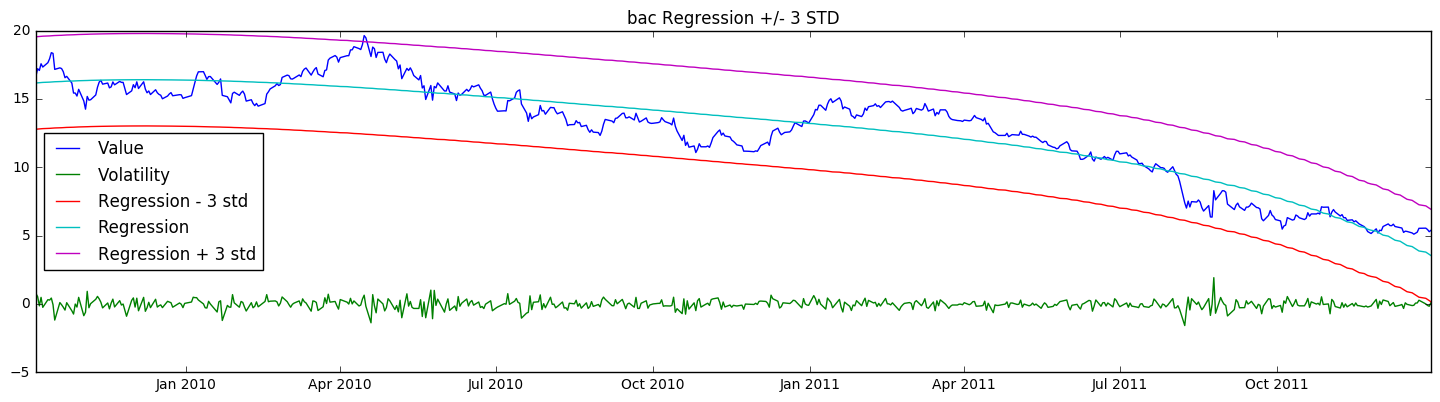

In [75]:
plt.figure(figsize=(18, 15))
ax1 = plt.subplot(3,1,1)
plt.plot(bacc['Open'], label='Value')
plt.plot(bacc['Volatility'], label='Volatility')
plt.plot(bacc['Regression'] - std_regression, label='Regression - 3 std')
plt.plot(bacc['Regression'], label='Regression')
plt.plot(bacc['Regression'] + std_regression, label='Regression + 3 std')
plt.legend(loc='best')
plt.title('bac Regression +/- 3 STD')

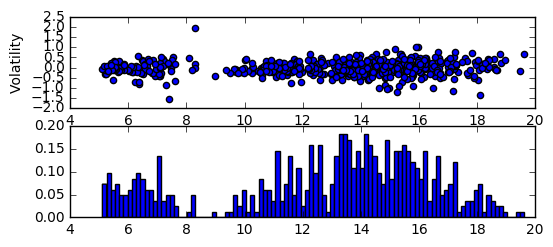

In [74]:
ax2 = plt.subplot(3,1,2)
plt.scatter(bacc['Open'], bacc['Volatility'])
plt.xlabel('Value')
plt.ylabel('Volatility')

ax3 = plt.subplot(3,1,3, sharex=ax2)
n_bins = 100
plt.hist(bacc['Open'], n_bins, normed=1, histtype='bar')

plt.show()

In [84]:
#Forecast

In [85]:
bac.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2006-10-02,53.529999,53.680000,53.299999,53.619999,43.512402,7378600
2006-10-03,53.630001,54.570000,53.570000,54.410000,44.153492,13591200
2006-10-04,54.290001,54.849998,54.150002,54.820000,44.486210,12570700
2006-10-05,54.560001,54.869999,54.270000,54.520000,44.242756,8653700
2006-10-06,54.349998,54.470001,54.110001,54.240002,44.015545,8968900


In [101]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back)]
		dataX.append(a)
		dataY.append(dataset[i + look_back])
	return np.array(dataX), np.array(dataY)

In [88]:
# fix random seed for reproducibility
np.random.seed(7)
# load the dataset
dataframe = bac['Adj Close']

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:321: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:356: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


Epoch 1/100
 - 5s - loss: 0.1265
Epoch 2/100
 - 4s - loss: 0.0146
Epoch 3/100
 - 4s - loss: 0.0011
Epoch 4/100
 - 4s - loss: 9.4744e-04
Epoch 5/100
 - 4s - loss: 8.4472e-04
Epoch 6/100
 - 4s - loss: 7.6122e-04
Epoch 7/100
 - 4s - loss: 6.9440e-04
Epoch 8/100
 - 4s - loss: 6.2448e-04
Epoch 9/100
 - 4s - loss: 6.0265e-04
Epoch 10/100
 - 4s - loss: 5.7423e-04
Epoch 11/100
 - 4s - loss: 5.6117e-04
Epoch 12/100
 - 4s - loss: 5.5728e-04
Epoch 13/100
 - 4s - loss: 5.5502e-04
Epoch 14/100
 - 4s - loss: 5.3992e-04
Epoch 15/100
 - 4s - loss: 5.4769e-04
Epoch 16/100
 - 4s - loss: 5.3755e-04
Epoch 17/100
 - 4s - loss: 5.3369e-04
Epoch 18/100
 - 4s - loss: 5.3675e-04
Epoch 19/100
 - 4s - loss: 5.5118e-04
Epoch 20/100
 - 4s - loss: 5.3669e-04
Epoch 21/100
 - 4s - loss: 5.4844e-04
Epoch 22/100
 - 4s - loss: 5.3777e-04
Epoch 23/100
 - 4s - loss: 5.5939e-04
Epoch 24/100
 - 4s - loss: 5.3358e-04
Epoch 25/100
 - 4s - loss: 5.2889e-04
Epoch 26/100
 - 4s - loss: 5.5128e-04
Epoch 27/100
 - 4s - loss: 5.4497

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


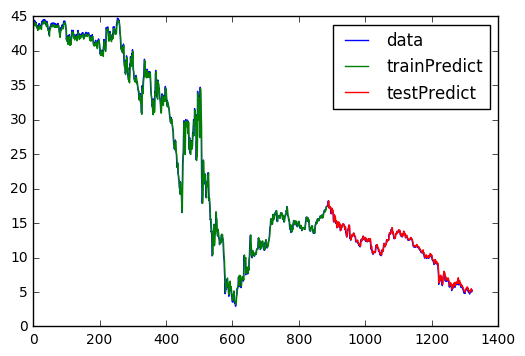

In [124]:
dataset = dataframe.values
dataset = dataset.astype('float32')
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size], dataset[train_size:len(dataset)]
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

# create and fit the LSTM network
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back] = trainPredict.squeeze()

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1] = testPredict.squeeze()

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset),label='data')
plt.plot(trainPredictPlot,label='trainPredict')
plt.plot(testPredictPlot,label='testPredict')
plt.legend(loc='best')
plt.show()

/usr/local/lib/python2.7/dist-packages/sklearn/preprocessing/data.py:374: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


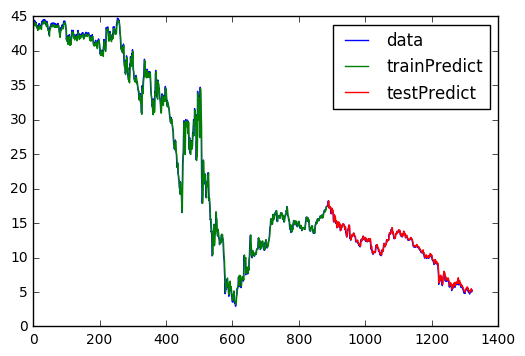

In [125]:
# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset),label='data')
plt.plot(trainPredictPlot,label='trainPredict')
plt.plot(testPredictPlot,label='testPredict')
plt.legend(loc='best')
plt.show()